In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
import missingno as msno
import warnings

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Setting the aesthetics for plots
sns.set_theme(style="whitegrid")

# Initial exploration

In [2]:
# Load the dataset
cirrhosis = pd.read_csv('./../../data/cirrhosis.csv')


# Glimpse the dataset
display(cirrhosis.info())

# Sample 3 random rows from the dataset
sampled_rows = cirrhosis.sample(n=3)

sampled_rows


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

None

ID  N_Days Status             Drug    Age Sex Ascites Hepatomegaly  \
273  274    1447     CL  D-penicillamine  17525   F       N            N   
362  363    2249      C              NaN  16071   F     NaN          NaN   
51    52    2386      D  D-penicillamine  18460   M       N            N   

    Spiders Edema  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos   SGOT  \
273       N     N        1.6          NaN     3.07   136.0    1995.0  128.0   
362     NaN     N        0.6          NaN     3.50     NaN       NaN    NaN   
51        N     N        6.0        614.0     3.70   158.0    5084.4  206.4   

     Tryglicerides  Platelets  Prothrombin  Stage  
273            NaN      372.0          9.6    4.0  
362            NaN      150.0          9.9    3.0  
51            93.0      362.0         10.6    1.0

### Summary of the data

In [3]:
def summary(df):
    # Summary for numeric columns
    numeric_columns = df.select_dtypes(include=['int', 'float']).columns
    numeric_summary = df[numeric_columns].describe()

    # Get missing values count only for numeric columns
    missing_values_numeric = df[numeric_columns].isnull().sum()

    # Create a DataFrame for missing values to align with numeric_summary
    missing_values_df = pd.DataFrame(missing_values_numeric, columns=['missing_values']).T

    # Combine the summaries using concat
    summary_df = pd.concat([numeric_summary, missing_values_df])

    # Display the numeric summary
    print('Summary of numeric columns')
    display(summary_df.transpose())

    # Summary for categorical columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    categorical_summary = pd.DataFrame(index=categorical_columns, columns=["mode", "freq", "missing_values"])
    for column in categorical_columns:
        mode = df[column].mode()
        if not mode.empty:
            mode_value = mode.iloc[0]
        else:
            mode_value = None
        freq = df[column].value_counts().iloc[0] if not df[column].empty else None
        missing = df[column].isnull().sum()
        categorical_summary.loc[column] = [mode_value, freq, missing]

    # Display the categorical summary
    print('Summary of categorical columns')
    display(categorical_summary)

In [4]:
summary(cirrhosis)

Summary of numeric columns


count          mean          std      min         25%  \
ID             418.0    209.500000   120.810458     1.00    105.2500   
N_Days         418.0   1917.782297  1104.672992    41.00   1092.7500   
Age            418.0  18533.351675  3815.845055  9598.00  15644.5000   
Bilirubin      418.0      3.220813     4.407506     0.30      0.8000   
Cholesterol    284.0    369.510563   231.944545   120.00    249.5000   
Albumin        418.0      3.497440     0.424972     1.96      3.2425   
Copper         310.0     97.648387    85.613920     4.00     41.2500   
Alk_Phos       312.0   1982.655769  2140.388824   289.00    871.5000   
SGOT           312.0    122.556346    56.699525    26.35     80.6000   
Tryglicerides  282.0    124.702128    65.148639    33.00     84.2500   
Platelets      407.0    257.024570    98.325585    62.00    188.5000   
Prothrombin    416.0     10.731731     1.022000     9.00     10.0000   
Stage          412.0      3.024272     0.882042     1.00      2.0000   

                    50%       75%       max  missing_values  
ID               209.50    313.75    418.00             0.0  
N_Days          1730.00   2613.50   4795.00             0.0  
Age            18628.00  21272.50  28650.00             0.0  
Bilirubin          1.40      3.40     28.00             0.0  
Cholesterol      309.50    400.00   1775.00           134.0  
Albumin            3.53      3.77      4.64             0.0  
Copper            73.00    123.00    588.00           108.0  
Alk_Phos        1259.00   1980.00  13862.40           106.0  
SGOT             114.70    151.90    457.25           106.0  
Tryglicerides    108.00    151.00    598.00           136.0  
Platelets        251.00    318.00    721.00            11.0  
Prothrombin       10.60     11.10     18.00             2.0  
Stage              3.00      4.00      4.00             6.0

Summary of categorical columns


mode freq missing_values
Status                      C  232              0
Drug          D-penicillamine  158            106
Sex                         F  374              0
Ascites                     N  288            106
Hepatomegaly                Y  160            106
Spiders                     N  222            106
Edema                       N  354              0

## Preprocessing; What types of data to handle?

Given the data:
- Numeric columns should be: Age, Bilirubin, Cholesterol, Albumin, Copper, Alk_Phos, SGOT, Tryglicerides, Platelets, Prothrombin.
    - Age should be transformed to years.

- The categoric columns that can be handled with binary variables are: Ascites, Hepatomegaly, and Spiders. No is 0 and Yes is 1. 

- For Drug, Placebo is 0 and D-penicillamine is 1.

- For Sex, we can have it as binary as well.

- Stage is a column that can be an ordinal column due to the inherent progression of the disease In the stage 0 is no problems, 1 is stage 1, and  so forth until 4 is stage 4 which is cirrhosis.

- Edema is a column that could be either ordinal, since no having edemas (N) is better than having them (Y). The in-between would be having edemas and using diuretics therapy (s). Hence, we could ass 0 to N, 1 to S, and 2, to Y.


In [5]:
# Convert 'NA' strings to actual NaN values
cirrhosis.replace('NA', pd.NA, inplace=True)
cirrhosis.replace('D-penicillamine', 'DPCA', inplace=True)

# Define column transformer for preprocessing
numeric_columns = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
categoric_columns = ['Sex', 'Drug', 'Ascites', 'Hepatomegaly', 'Spiders', 'Status', 'Edema', 'Stage']

# Subsets of categoric columns
binary_columns = ['Sex', 'Drug', 'Ascites', 'Hepatomegaly', 'Spiders']
presence_mapping = {'N': 0, 'Y': 0}
binary_mappings = {
    'Sex': {'M': 1, 'F': 0},
    'Drug': {'DPCA': 1, 'Placebo': 0},
    'Ascites': presence_mapping, 
    'Hepatomegaly': presence_mapping, 
    'Spiders': presence_mapping
}
onehot_columns = ['Status']
ordinal_columns = ['Edema', 'Stage']
ordinal_orders = {
    'Edema': ['N', 'S', 'Y'], 
    'Stage': [1, 2, 3, 4]
}

# Convert Age from days to years and round to 1 decimal place
cirrhosis['Age'] = (cirrhosis['Age'] / 365).round(1)

# Convert categoric to such
cirrhosis[categoric_columns] = cirrhosis[categoric_columns].astype('category')

# Define order of ordinal 
for column in ordinal_columns:
    cirrhosis[column] = pd.Categorical(cirrhosis[column], categories=ordinal_orders[column], ordered=True)


# Only use the defined columns
cirrhosis = cirrhosis[numeric_columns + categoric_columns]

# Display the transformed DataFrame
display(cirrhosis.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   N_Days         418 non-null    int64   
 1   Age            418 non-null    float64 
 2   Bilirubin      418 non-null    float64 
 3   Cholesterol    284 non-null    float64 
 4   Albumin        418 non-null    float64 
 5   Copper         310 non-null    float64 
 6   Alk_Phos       312 non-null    float64 
 7   SGOT           312 non-null    float64 
 8   Tryglicerides  282 non-null    float64 
 9   Platelets      407 non-null    float64 
 10  Prothrombin    416 non-null    float64 
 11  Sex            418 non-null    category
 12  Drug           312 non-null    category
 13  Ascites        312 non-null    category
 14  Hepatomegaly   312 non-null    category
 15  Spiders        312 non-null    category
 16  Status         418 non-null    category
 17  Edema          418 non-null    cate

None

In [6]:
summary(cirrhosis)

Summary of numeric columns


count         mean          std     min        25%      50%  \
N_Days         418.0  1917.782297  1104.672992   41.00  1092.7500  1730.00   
Age            418.0    50.767703    10.453390   26.30    42.8500    51.00   
Bilirubin      418.0     3.220813     4.407506    0.30     0.8000     1.40   
Cholesterol    284.0   369.510563   231.944545  120.00   249.5000   309.50   
Albumin        418.0     3.497440     0.424972    1.96     3.2425     3.53   
Copper         310.0    97.648387    85.613920    4.00    41.2500    73.00   
Alk_Phos       312.0  1982.655769  2140.388824  289.00   871.5000  1259.00   
SGOT           312.0   122.556346    56.699525   26.35    80.6000   114.70   
Tryglicerides  282.0   124.702128    65.148639   33.00    84.2500   108.00   
Platelets      407.0   257.024570    98.325585   62.00   188.5000   251.00   
Prothrombin    416.0    10.731731     1.022000    9.00    10.0000    10.60   

                    75%       max  missing_values  
N_Days         2613.500   4795.00             0.0  
Age              58.275     78.50             0.0  
Bilirubin         3.400     28.00             0.0  
Cholesterol     400.000   1775.00           134.0  
Albumin           3.770      4.64             0.0  
Copper          123.000    588.00           108.0  
Alk_Phos       1980.000  13862.40           106.0  
SGOT            151.900    457.25           106.0  
Tryglicerides   151.000    598.00           136.0  
Platelets       318.000    721.00            11.0  
Prothrombin      11.100     18.00             2.0

Summary of categorical columns


mode freq missing_values
Sex              F  374              0
Drug          DPCA  158            106
Ascites          N  288            106
Hepatomegaly     Y  160            106
Spiders          N  222            106
Status           C  232              0
Edema            N  354              0
Stage            3  155              6

## Missing data

Visualization of how the matrix looks with misisng values


<Axes: >

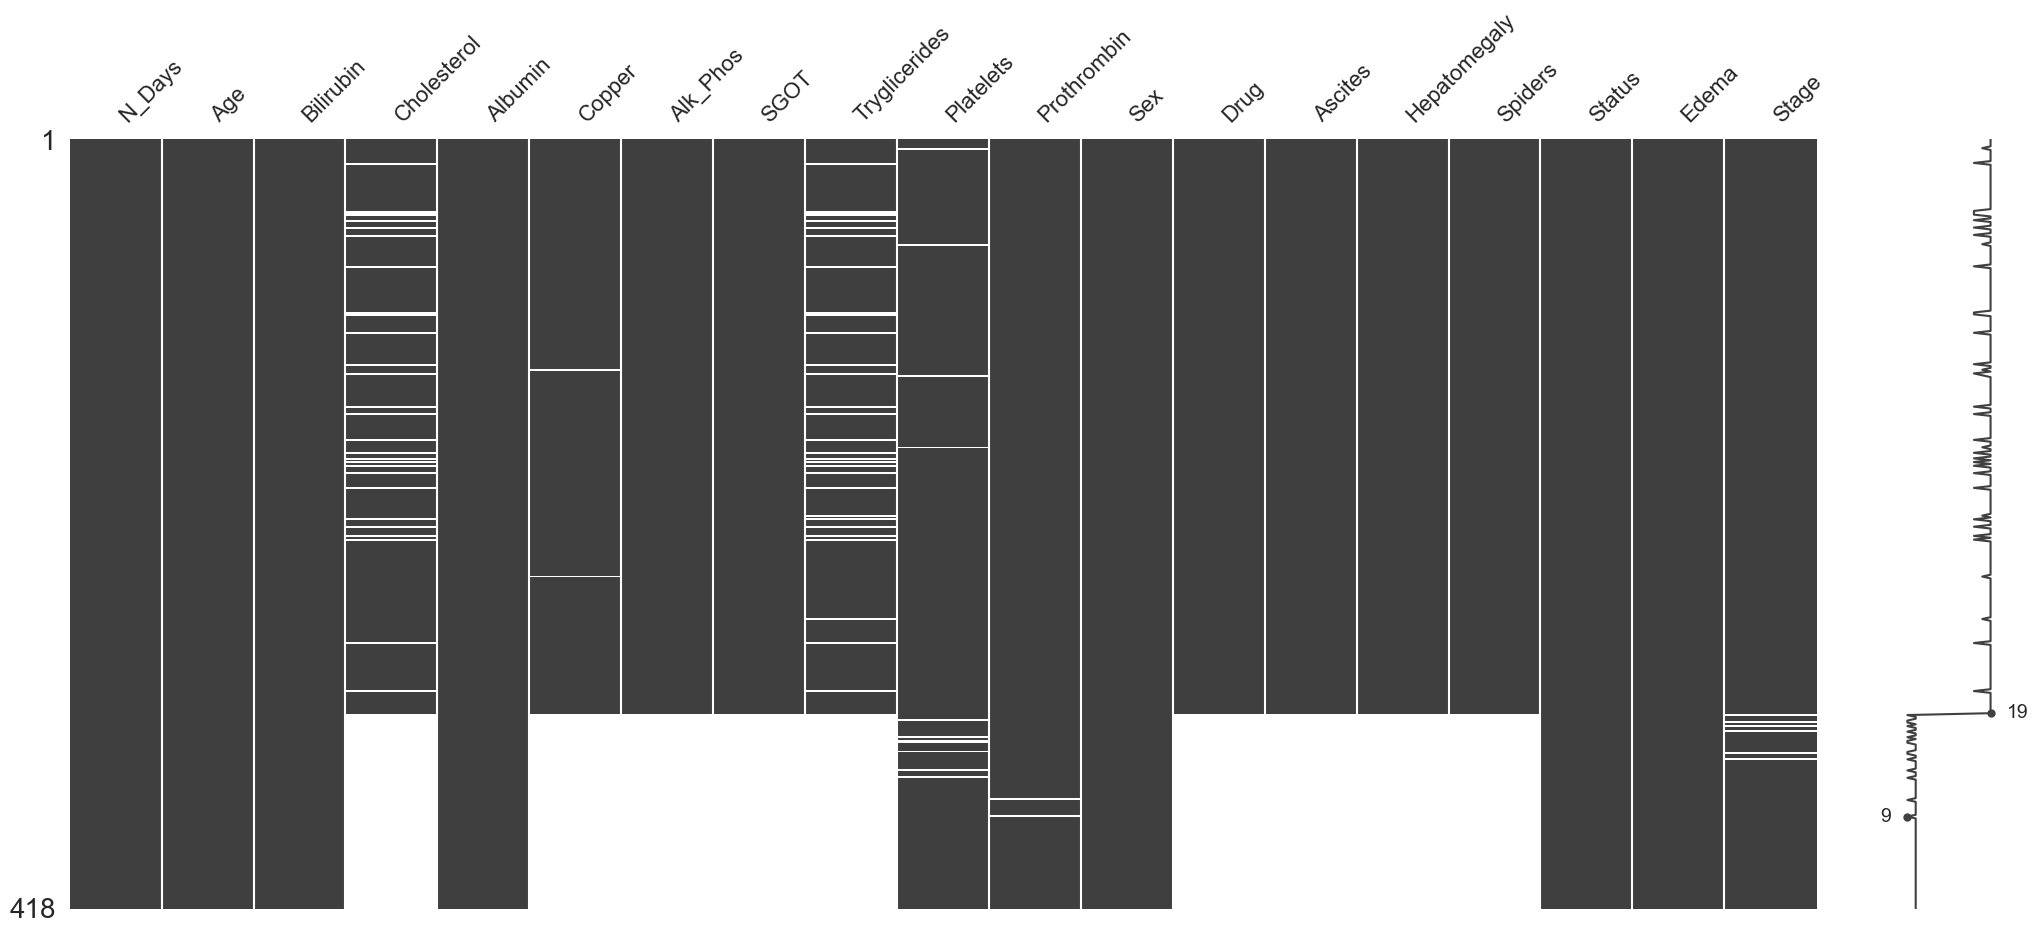

In [7]:
# Visualize the missing data pattern
print('Visualization of how the matrix looks with misisng values')
msno.matrix(cirrhosis)

The last rows where the drug is missing, could potentially be the rows of the 106 patients who did not participate in the trial. For now, I'll remove them just to follow the tutorial.

Number of rows and columns after removing NAs in Drug column: (312, 19)


<Axes: >

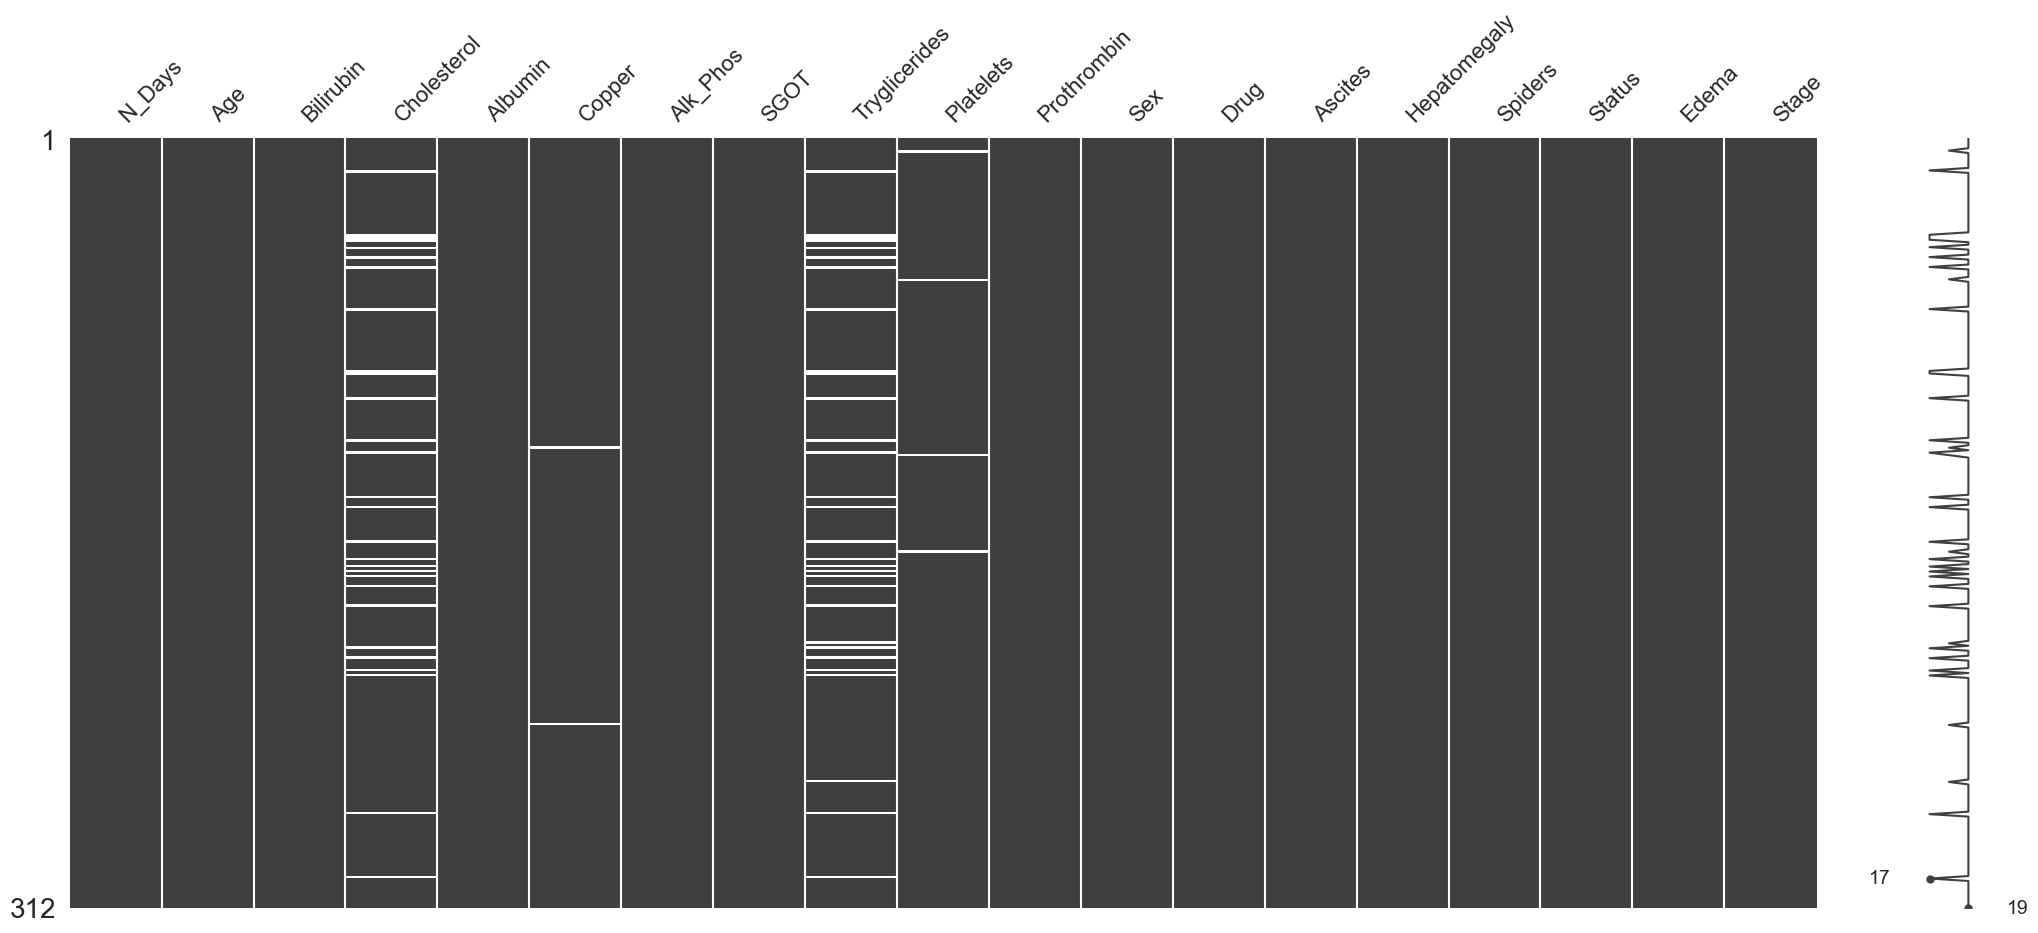

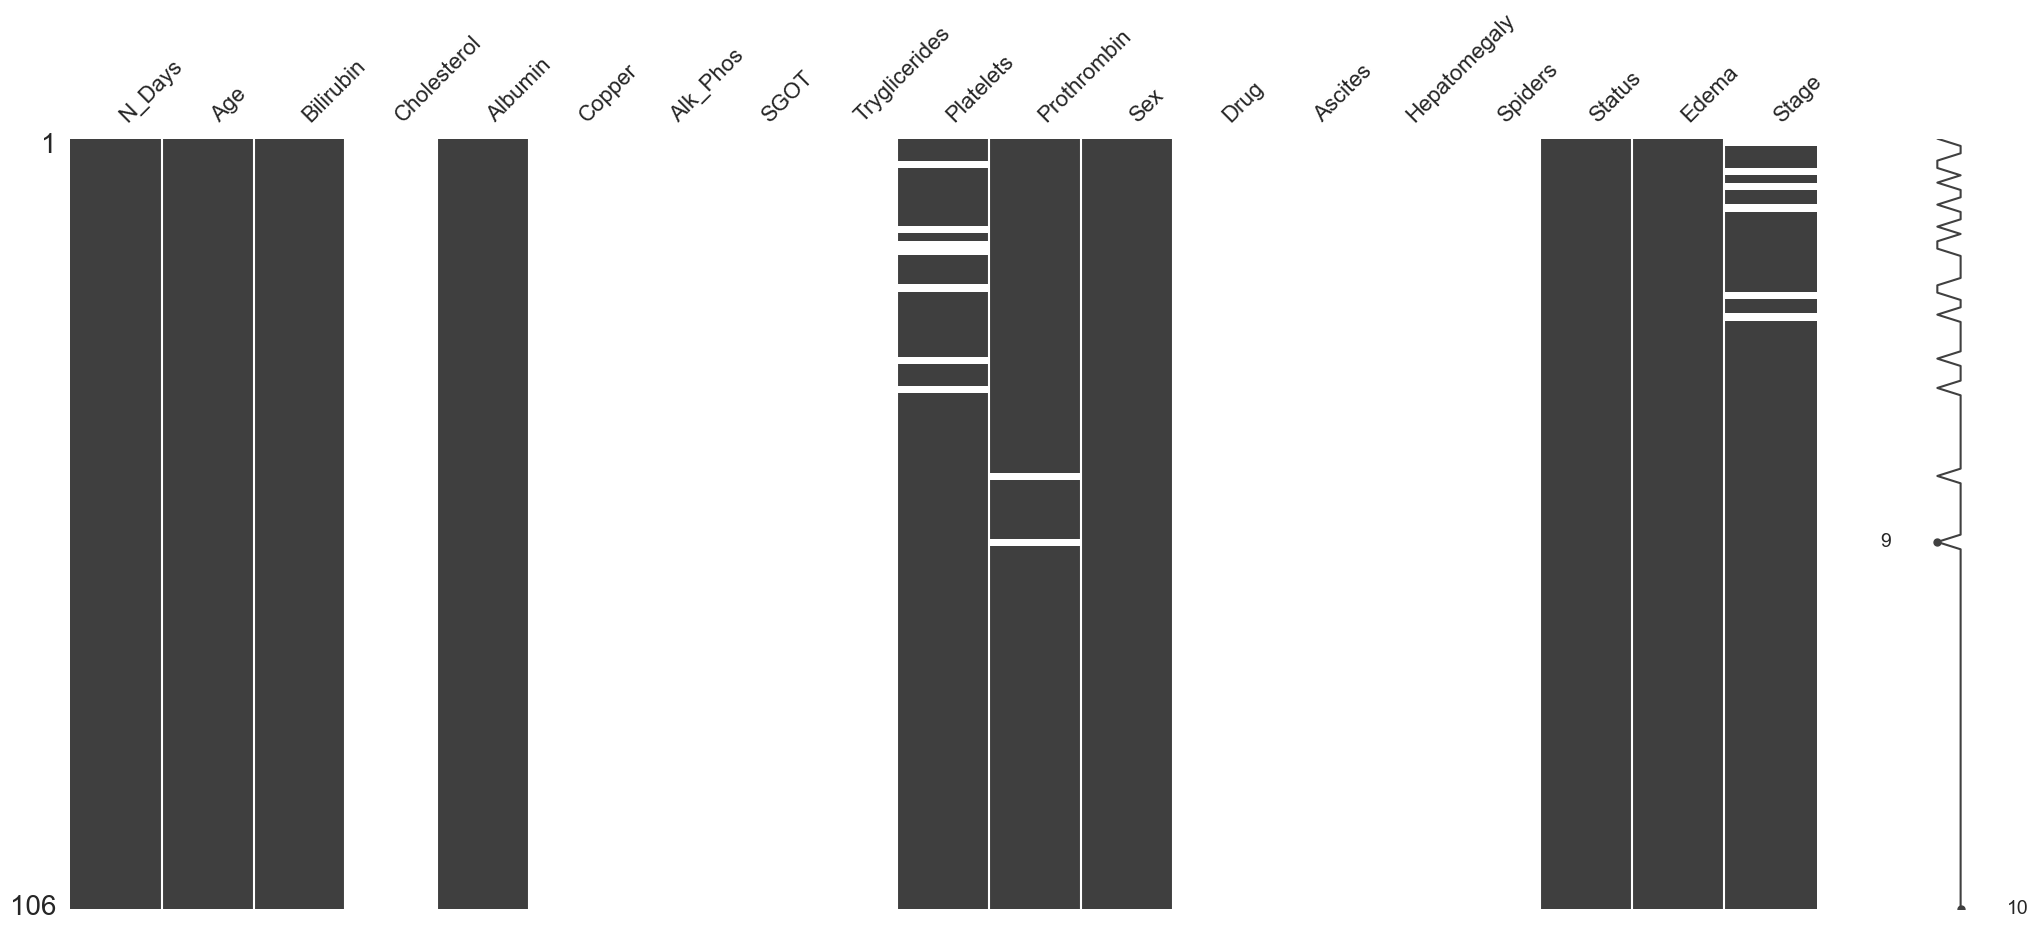

In [8]:
# Filter out rows where 'Drug' column is NA
trials = cirrhosis.dropna(subset=['Drug'])
non_trials = cirrhosis.query('Drug.isna()').reset_index(drop=True)

# Get the dimensions of the DataFrame
dimensions = trials.shape

# Display the dimensions
print('Number of rows and columns after removing NAs in Drug column:', dimensions)

# Visualize the missing data pattern
msno.matrix(trials)
msno.matrix(non_trials)

In [9]:
summary(non_trials)

Summary of numeric columns


count         mean          std    min      25%      50%  \
N_Days         106.0  1657.056604  1008.558914  41.00  998.000  1397.00   
Age            106.0    52.868868     9.785600  33.00   46.000    53.00   
Bilirubin      106.0     3.116981     4.042947   0.40    0.725     1.40   
Cholesterol      0.0          NaN          NaN    NaN      NaN      NaN   
Albumin        106.0     3.431038     0.434820   2.31    3.125     3.47   
Copper           0.0          NaN          NaN    NaN      NaN      NaN   
Alk_Phos         0.0          NaN          NaN    NaN      NaN      NaN   
SGOT             0.0          NaN          NaN    NaN      NaN      NaN   
Tryglicerides    0.0          NaN          NaN    NaN      NaN      NaN   
Platelets       99.0   241.747475   105.383008  76.00  165.500   226.00   
Prothrombin    104.0    10.750000     1.078114   9.00   10.100    10.60   

                    75%      max  missing_values  
N_Days         2262.500  4795.00             0.0  
Age              61.000    75.10             0.0  
Bilirubin         3.075    18.00             0.0  
Cholesterol         NaN      NaN           106.0  
Albumin           3.720     4.52             0.0  
Copper              NaN      NaN           106.0  
Alk_Phos            NaN      NaN           106.0  
SGOT                NaN      NaN           106.0  
Tryglicerides       NaN      NaN           106.0  
Platelets       286.000   721.00             7.0  
Prothrombin      11.000    18.00             2.0

Summary of categorical columns


mode freq missing_values
Sex              F   98              0
Drug          None    0            106
Ascites       None    0            106
Hepatomegaly  None    0            106
Spiders       None    0            106
Status           C   64              0
Edema            N   91              0
Stage            3   35              6

## Initial visualiuzation of descriptives

In [87]:
column_units = {
    'N_Days': 'Days', 
    'Age': 'Age (years)', 
    'Bilirubin': 'Serum bilirubin in [mg/dl]', 
    'Cholesterol': 'Serum cholesterol in [mg/dl]', 
    'Albumin': 'Albumin in [gm/dl]', 
    'Copper': 'Urine copper in [ug/day]', 
    'Alk_Phos': 'Alkaline phosphatase in [U/liter]', 
    'SGOT': 'SGOT in [U/ml]', 
    'Tryglicerides': 'Triglycerides in [mg/dl]', 
    'Platelets': 'Platelets per cubic [ml/1000]', 
    'Prothrombin': 'Prothrombin time in seconds [s]', 
    'Sex': 'Sex', 
    'Drug': 'Type of drug', 
    'Ascites': 'Ascites', 
    'Hepatomegaly': 'Hepatomegaly', 
    'Spiders': 'Spiders', 
    'Status': 'Status', 
    'Edema': 'Edema', 
    'Stage': 'Stage'
}
presence_description = {'N': 'No', 'Y': 'Yes'} 
category_description = {
    'Stage': {1: '1', 2: '2', 3: '3', 4: '4'},
    'Drug': {'DPCA': 'DPCA', 'Placebo': 'Placebo'},
    'Sex': {'M': 'Male', 'F': 'Female'}, 
    'Ascites': presence_description, 
    'Hepatomegaly': presence_description, 
    'Spiders': presence_description, 
    'Status': {'C': 'Censored', 'CL': 'Liver tx', 'D': 'Death'}, 
    'Edema': {'N': 'No edema', 'S': 'Diuretic no edema', 'Y': 'Edema & diuretic'}
}
presence_palette = {'Y': '#4c72b0', 'N': '#dd8452'}
color_palette = {
    'Sex': {'M': '#4c72b0', 'F': '#da8bc3'}, 
    'Ascites': {'Y': '#c44e52', 'N': '#55a868'}, 
    'Hepatomegaly': {'Y': '#c44e52', 'N': '#55a868'}, 
    'Spiders': {'Y': '#c44e52', 'N': '#55a868'}, 
    'Status': {'C': '#64b5cd', 'CL': '#ccb974', 'D': '#8c8c8c'}, 
    'Edema': {'N': '#55a868', 'S': '#4c72b0', 'Y': '#c44e52'},
    'Stage': {1: '#55a868', 2: '#4c72b0', 3: '#dd8452', 4: '#c44e52'},
    'Drug': {'DPCA': '#4c72b0', 'Placebo': '#ccb974'}
}

display(sns.color_palette())
print(sns.color_palette().as_hex())

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']


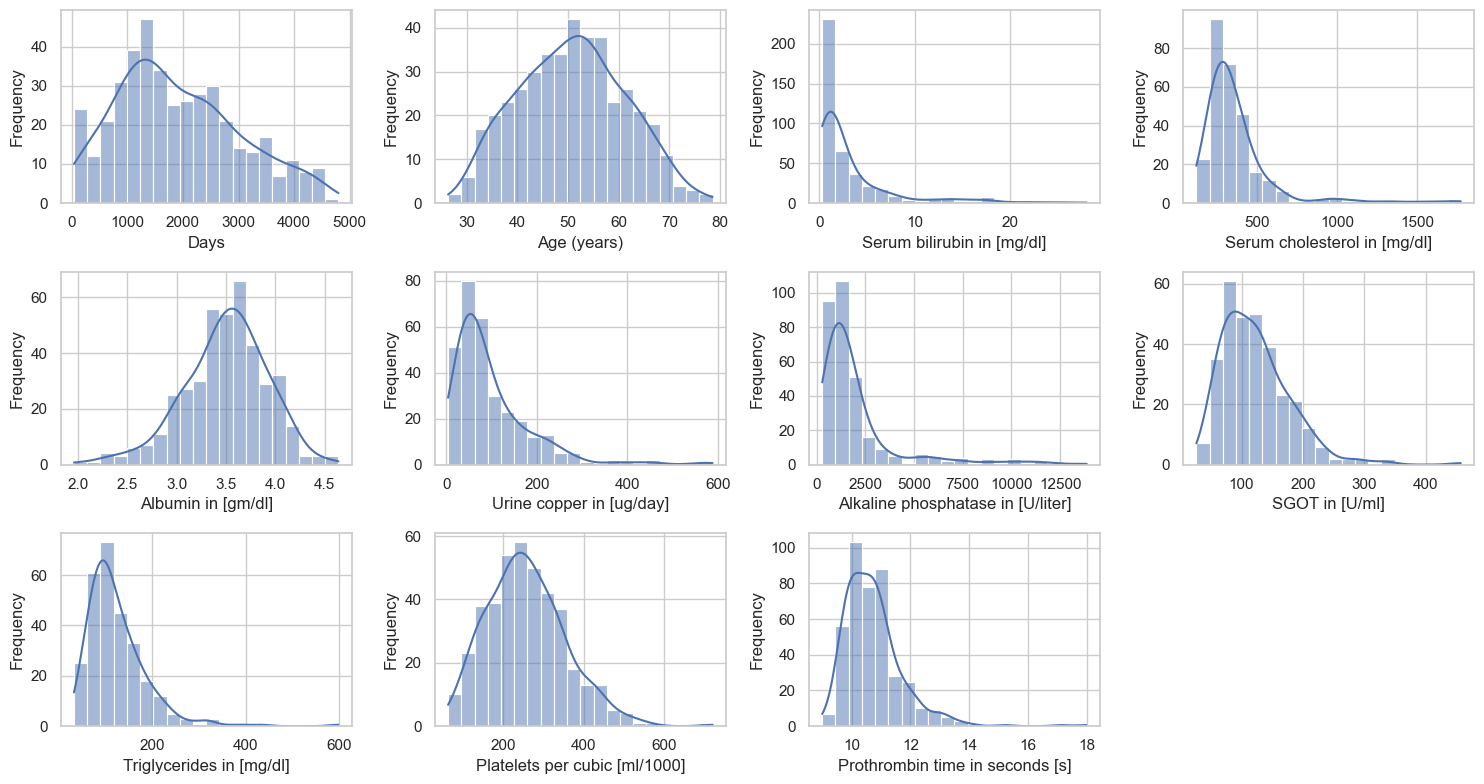

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograms
plt.figure(figsize=(15, 8))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(3, 4, i)
    sns.histplot(data=cirrhosis, x=column, bins=20, kde=True)
    plt.xlabel(column_units[column])
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

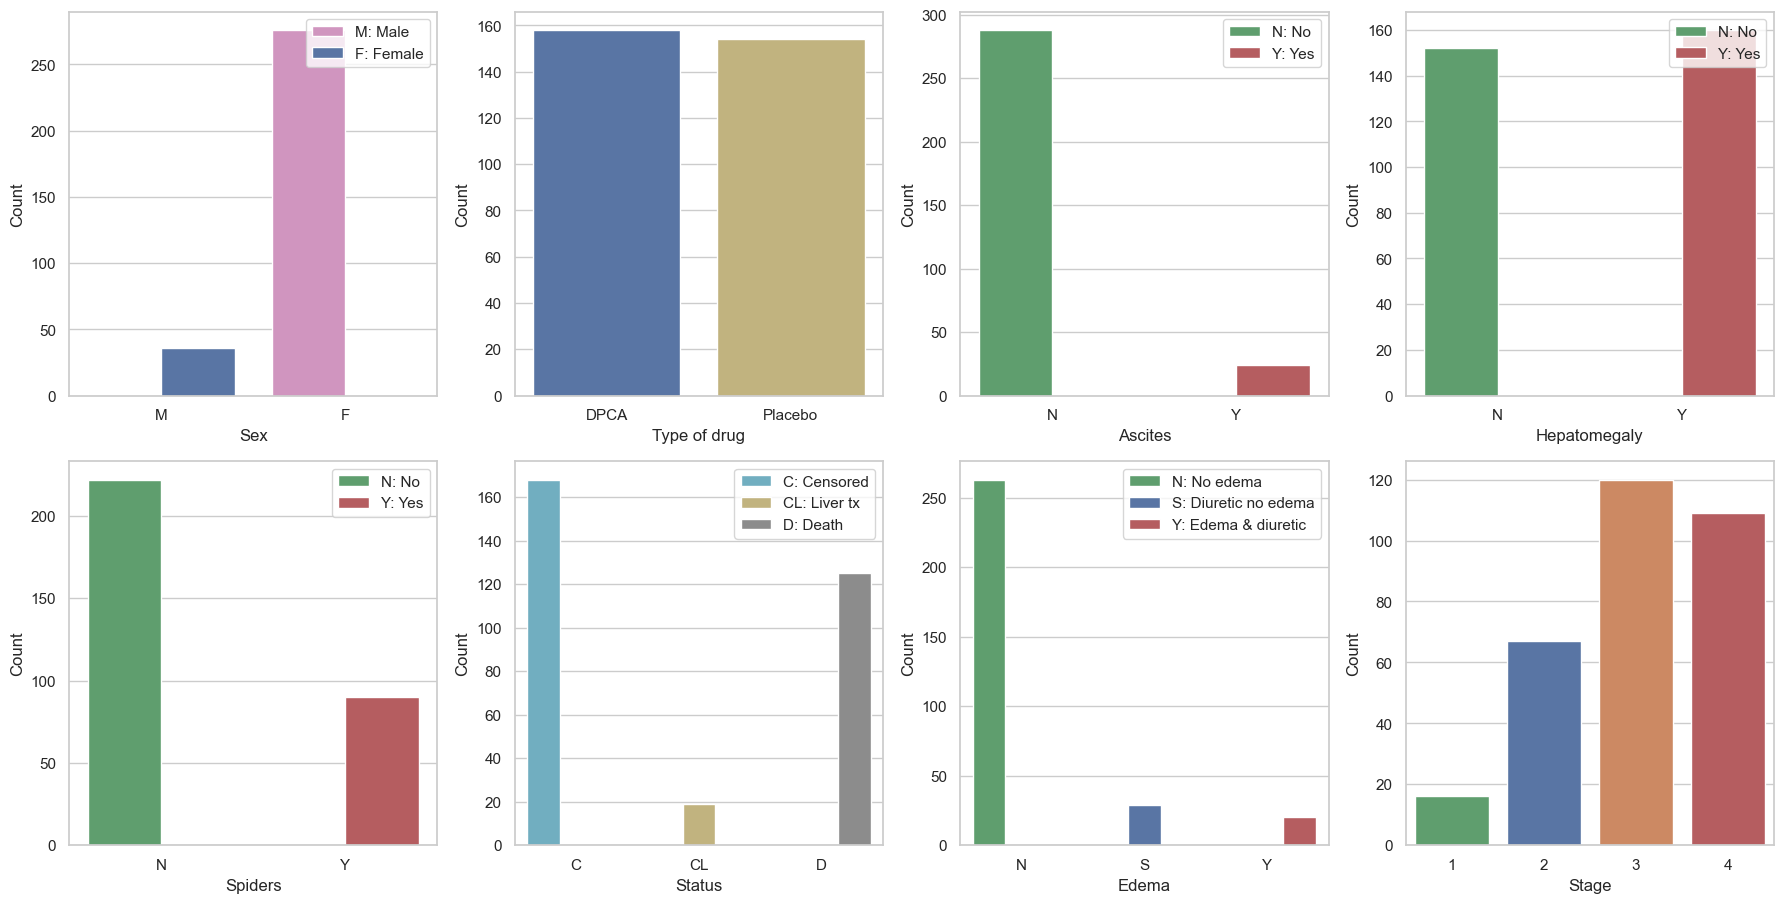

In [58]:
plt.figure(figsize=(18, 10))

# Loop through each categorical column
for i, column in enumerate(categoric_columns, 1):
    plt.subplot(2, 4, i)  # Create a subplot

    # Define the order of the categories and plot the countplot
    if column in category_description:
        order = list(category_description[column].keys())  # Explicit order from descriptions
        sns.countplot(data=trials, x=column, hue=column, order=order, palette=color_palette[column])
        # Create legend labels based on the order and descriptions
        legend_labels = [f"{cat}: {category_description[column][cat]}" for cat in order]
        plt.legend(loc='upper right', labels=legend_labels)
    else:
        sns.countplot(data=trials, x=column, palette=color_palette[column])

    # Set labels
    plt.xlabel(column_units.get(column, column))
    plt.ylabel('Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout
plt.show()  # Show the plot

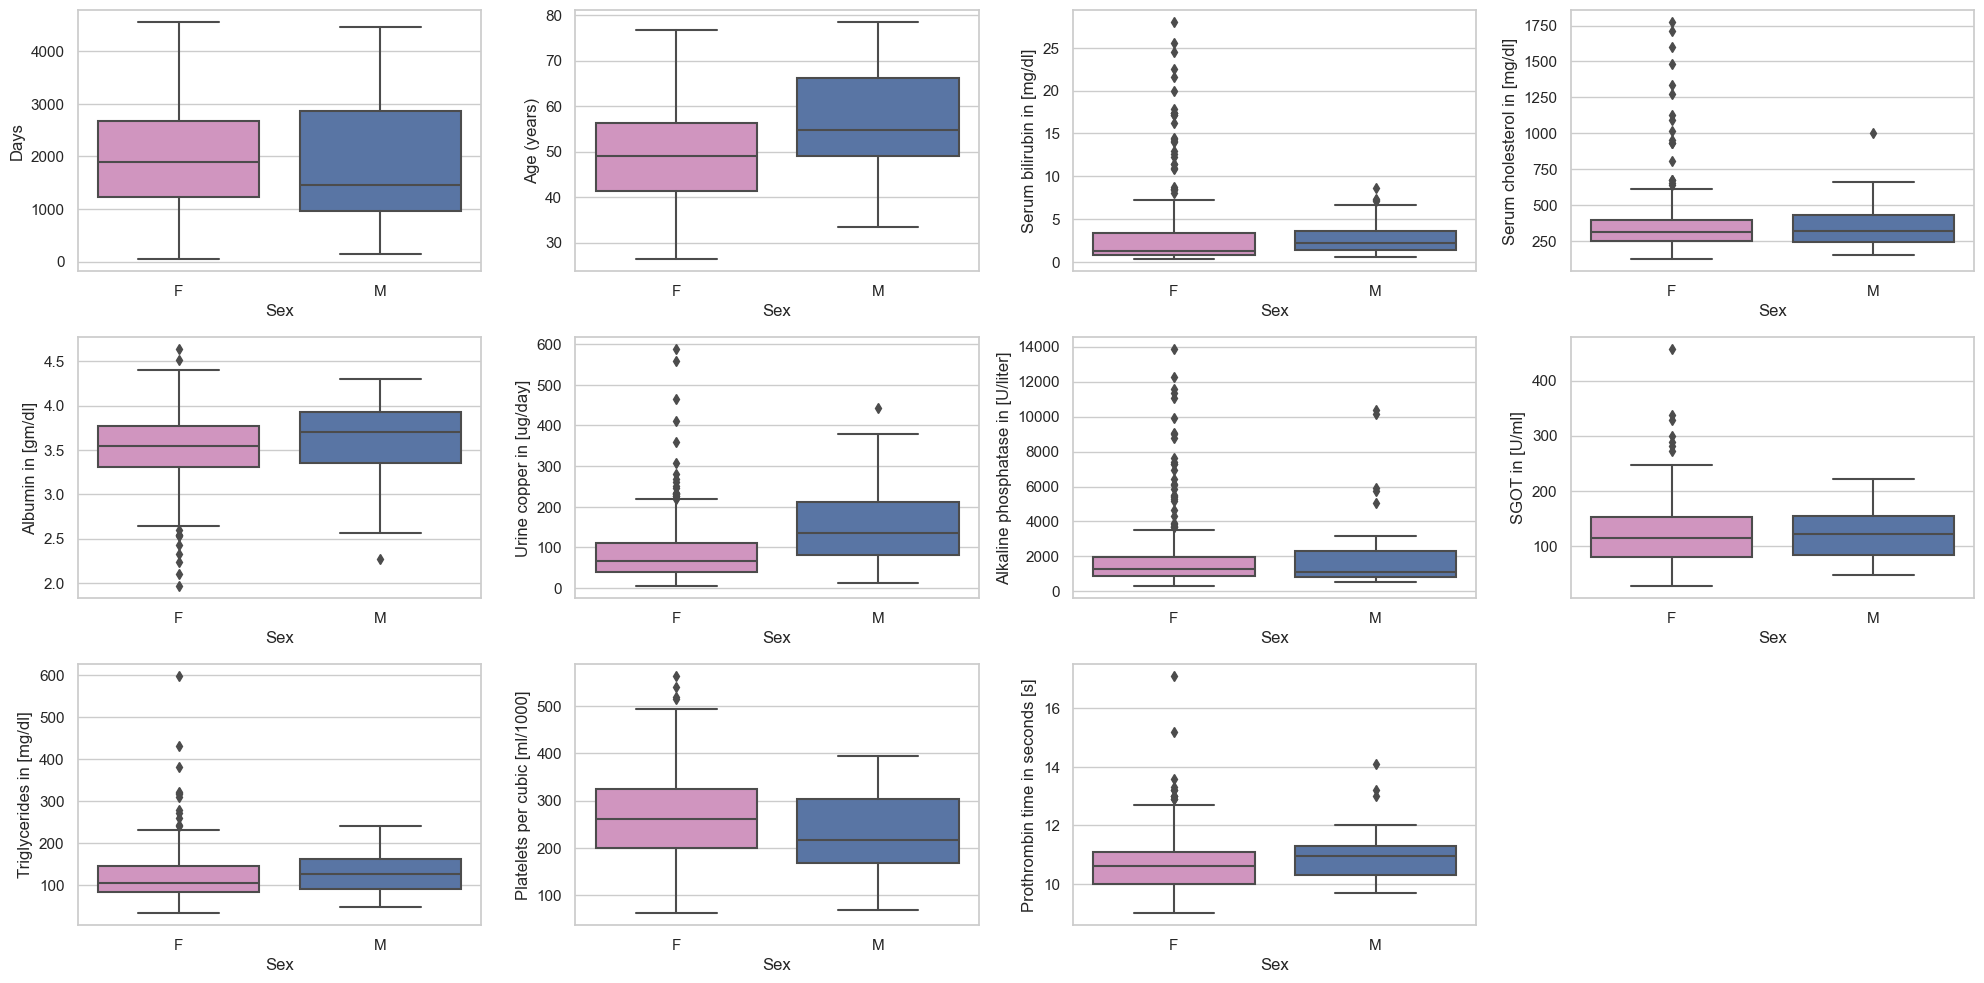

###########


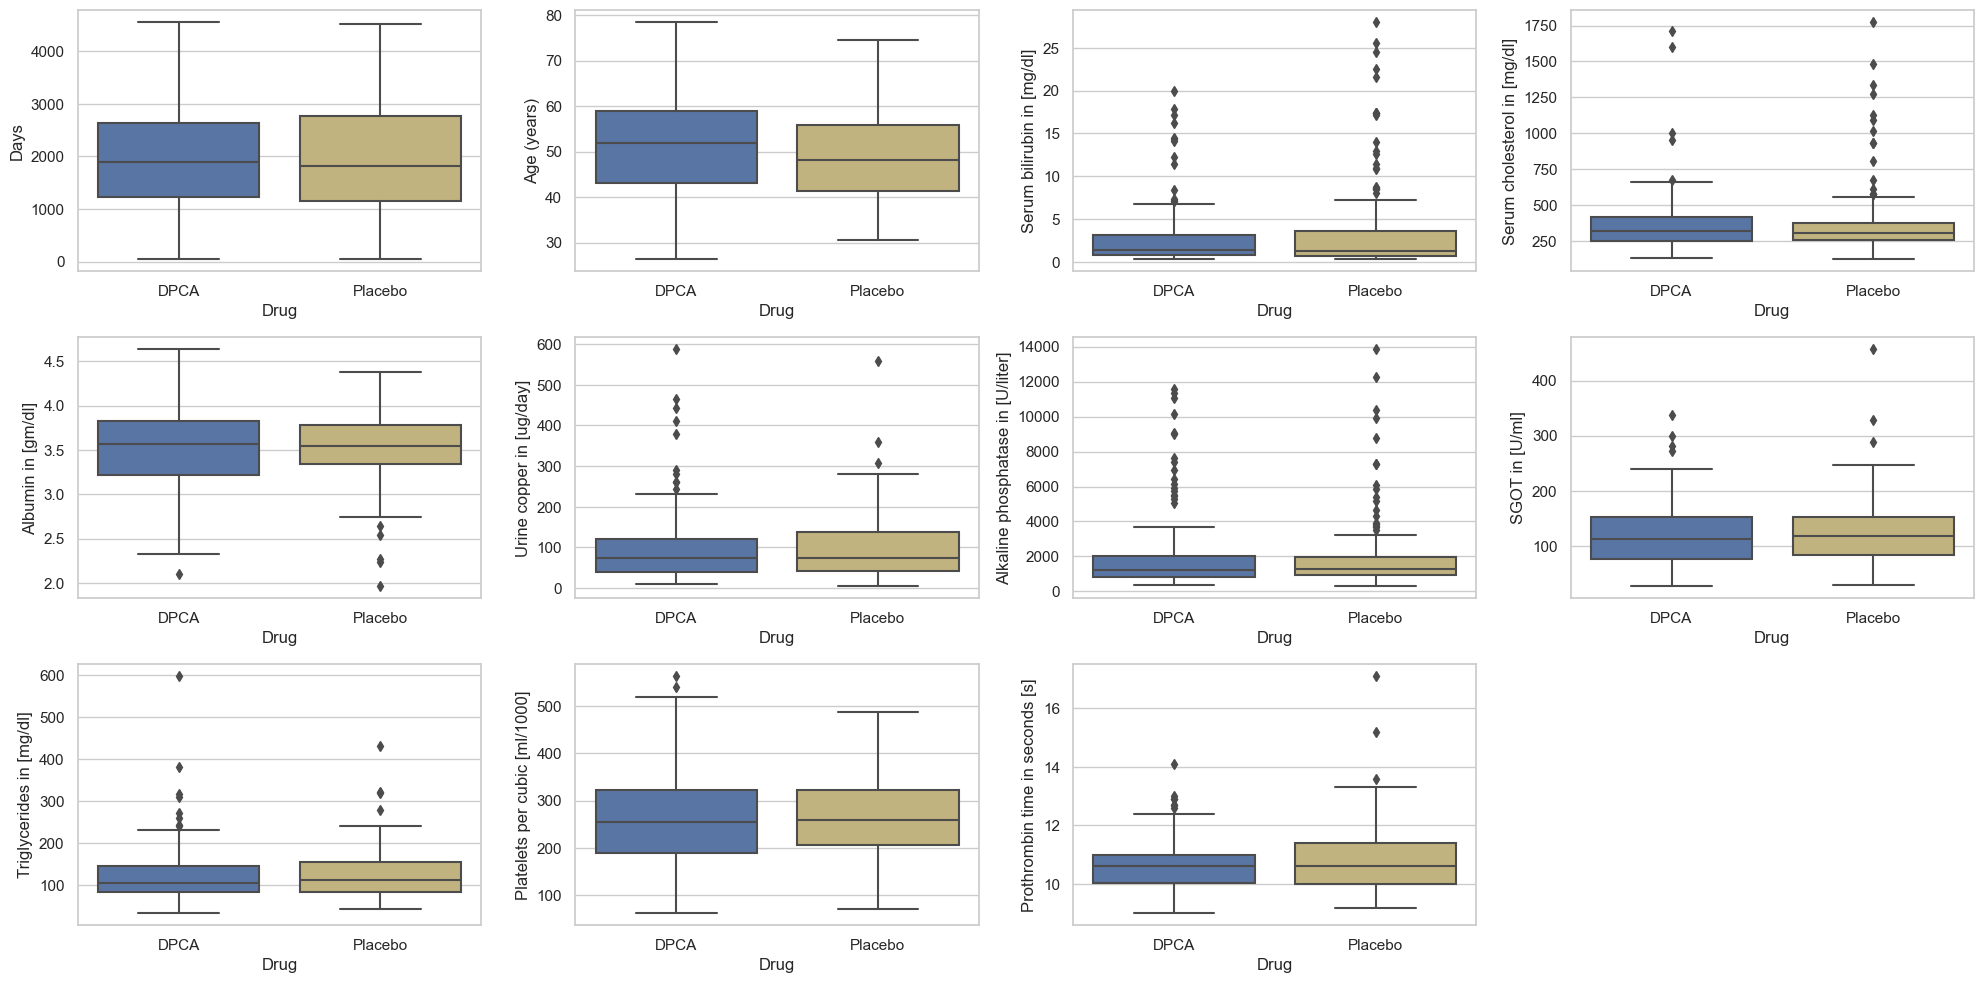

###########


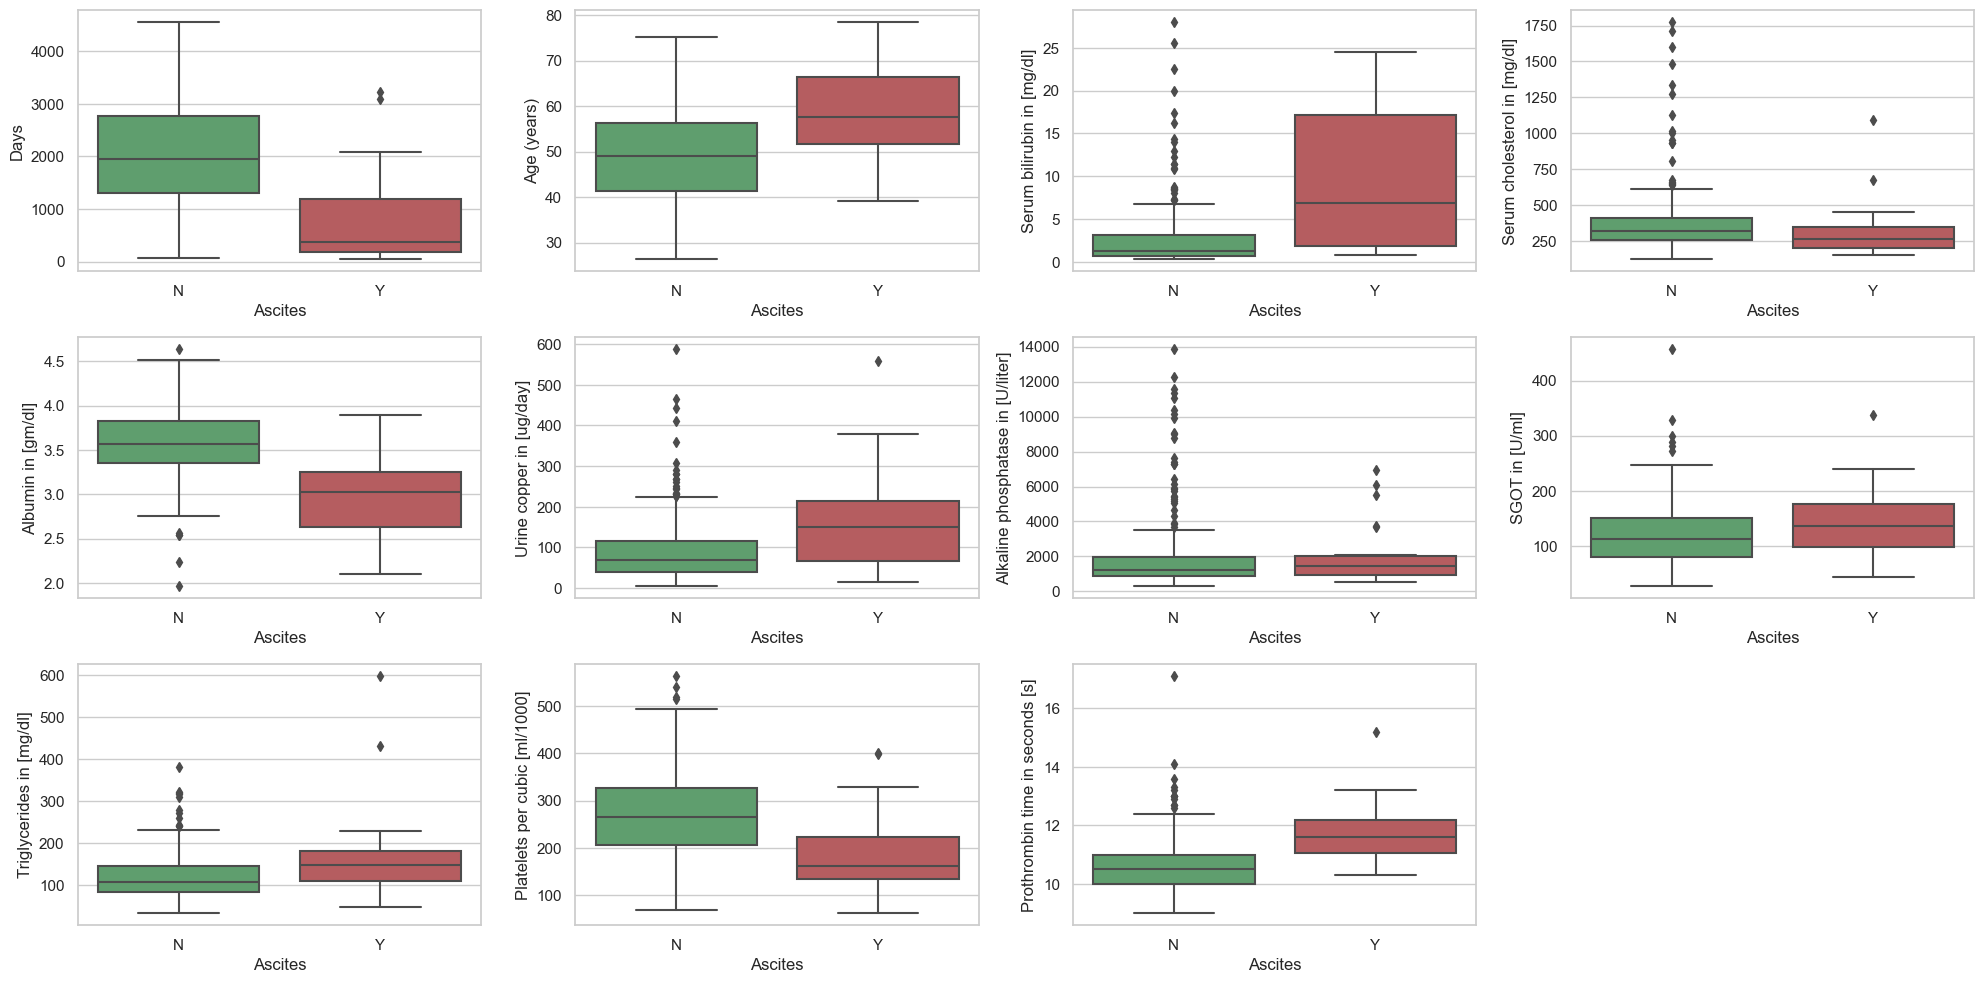

###########


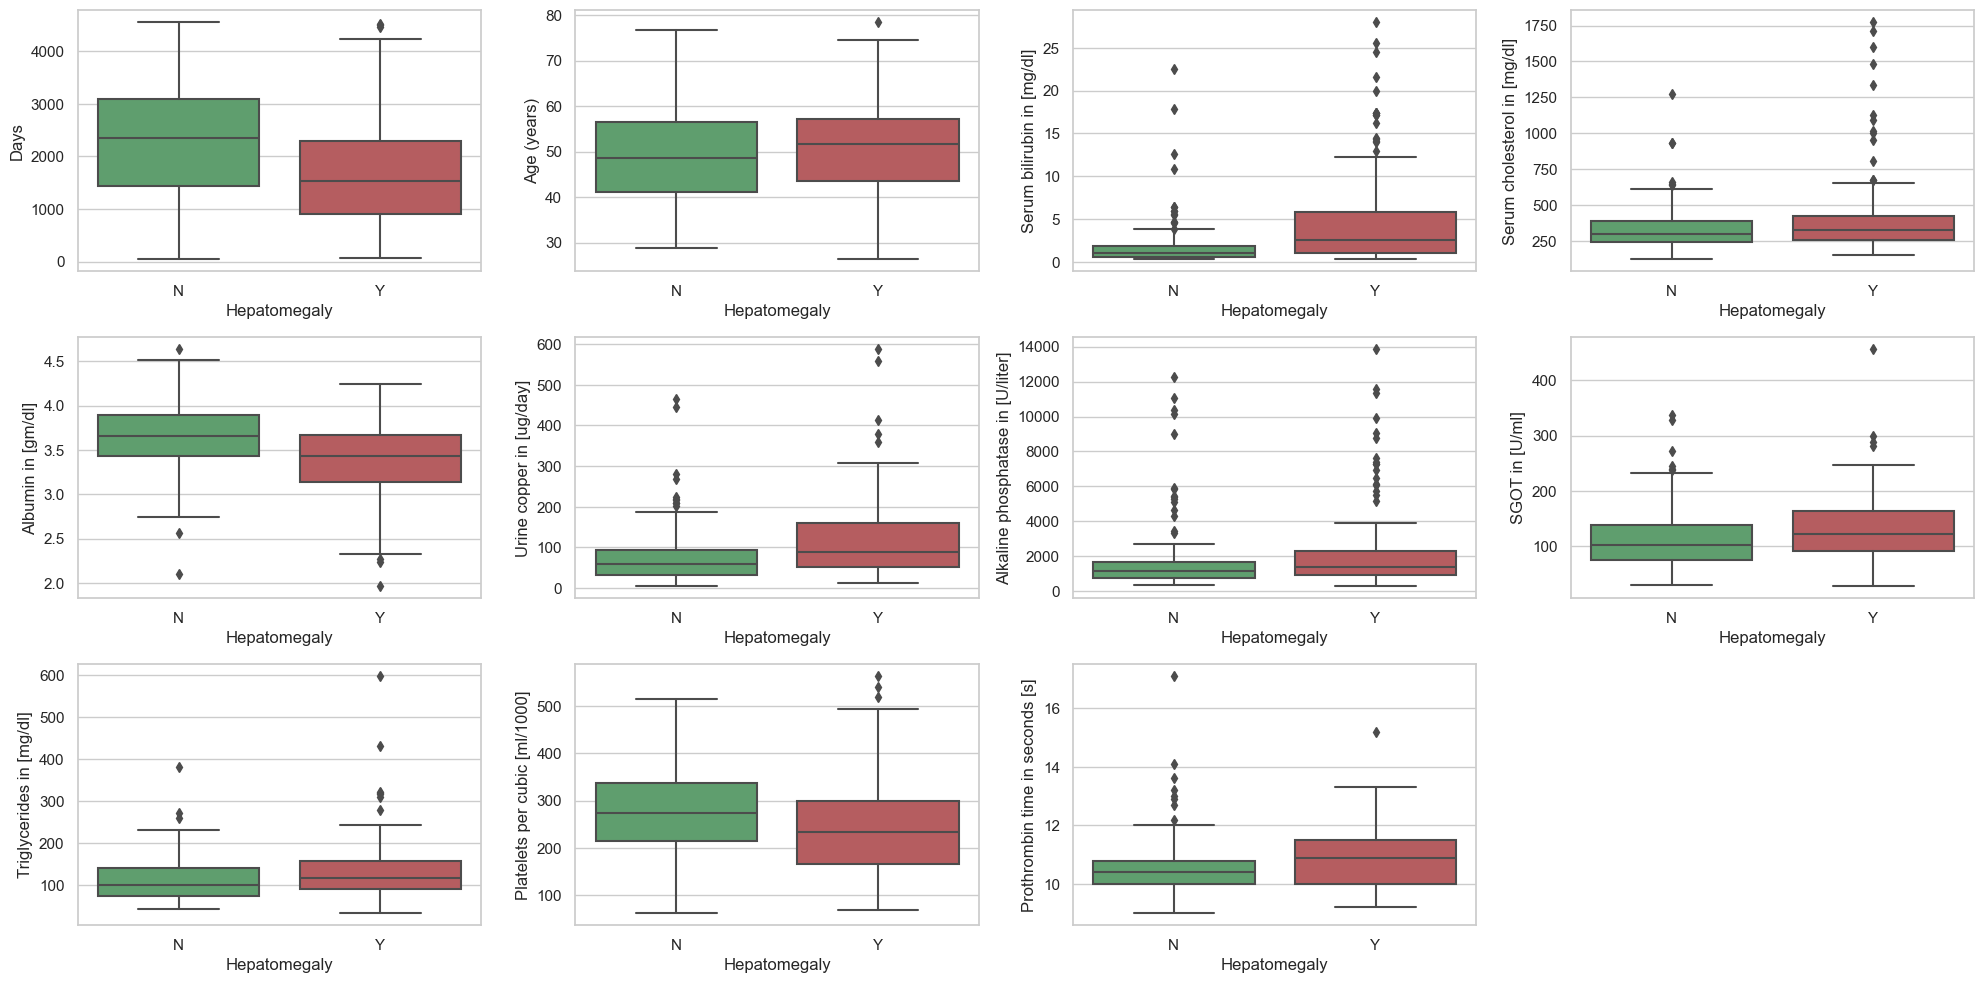

###########


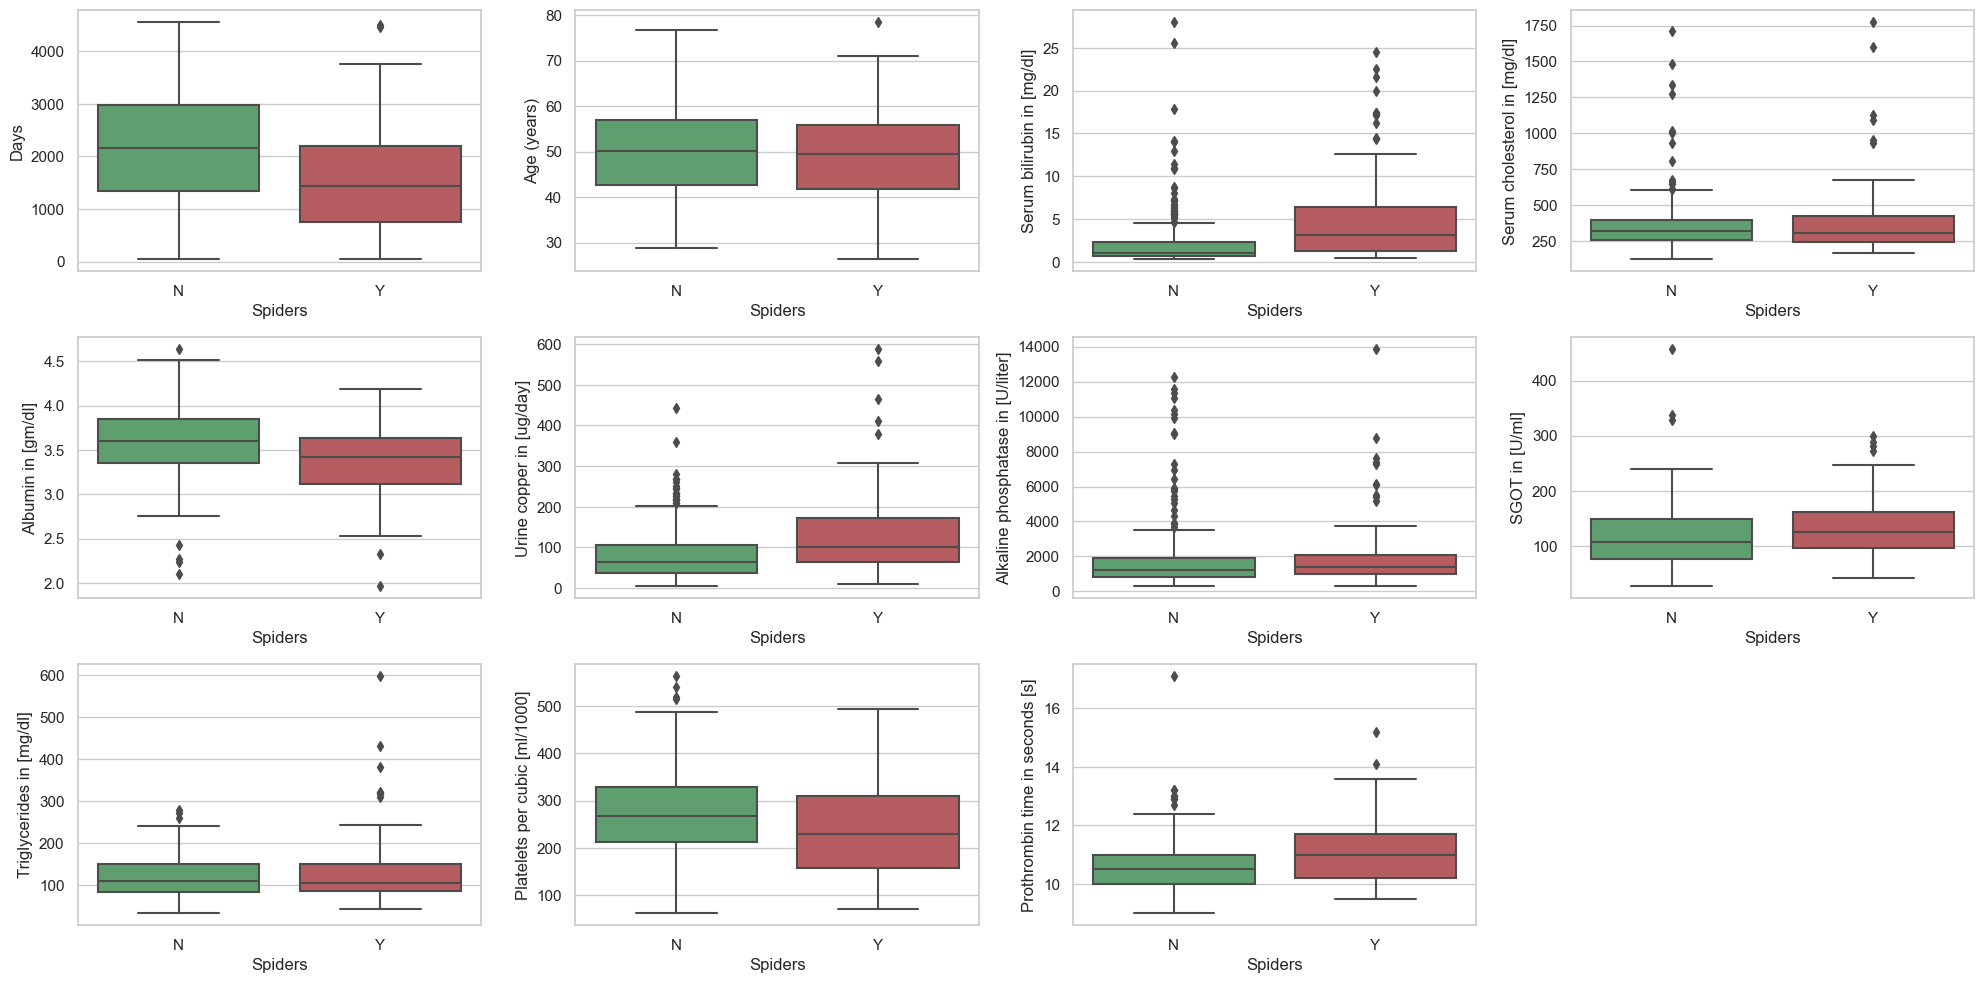

###########


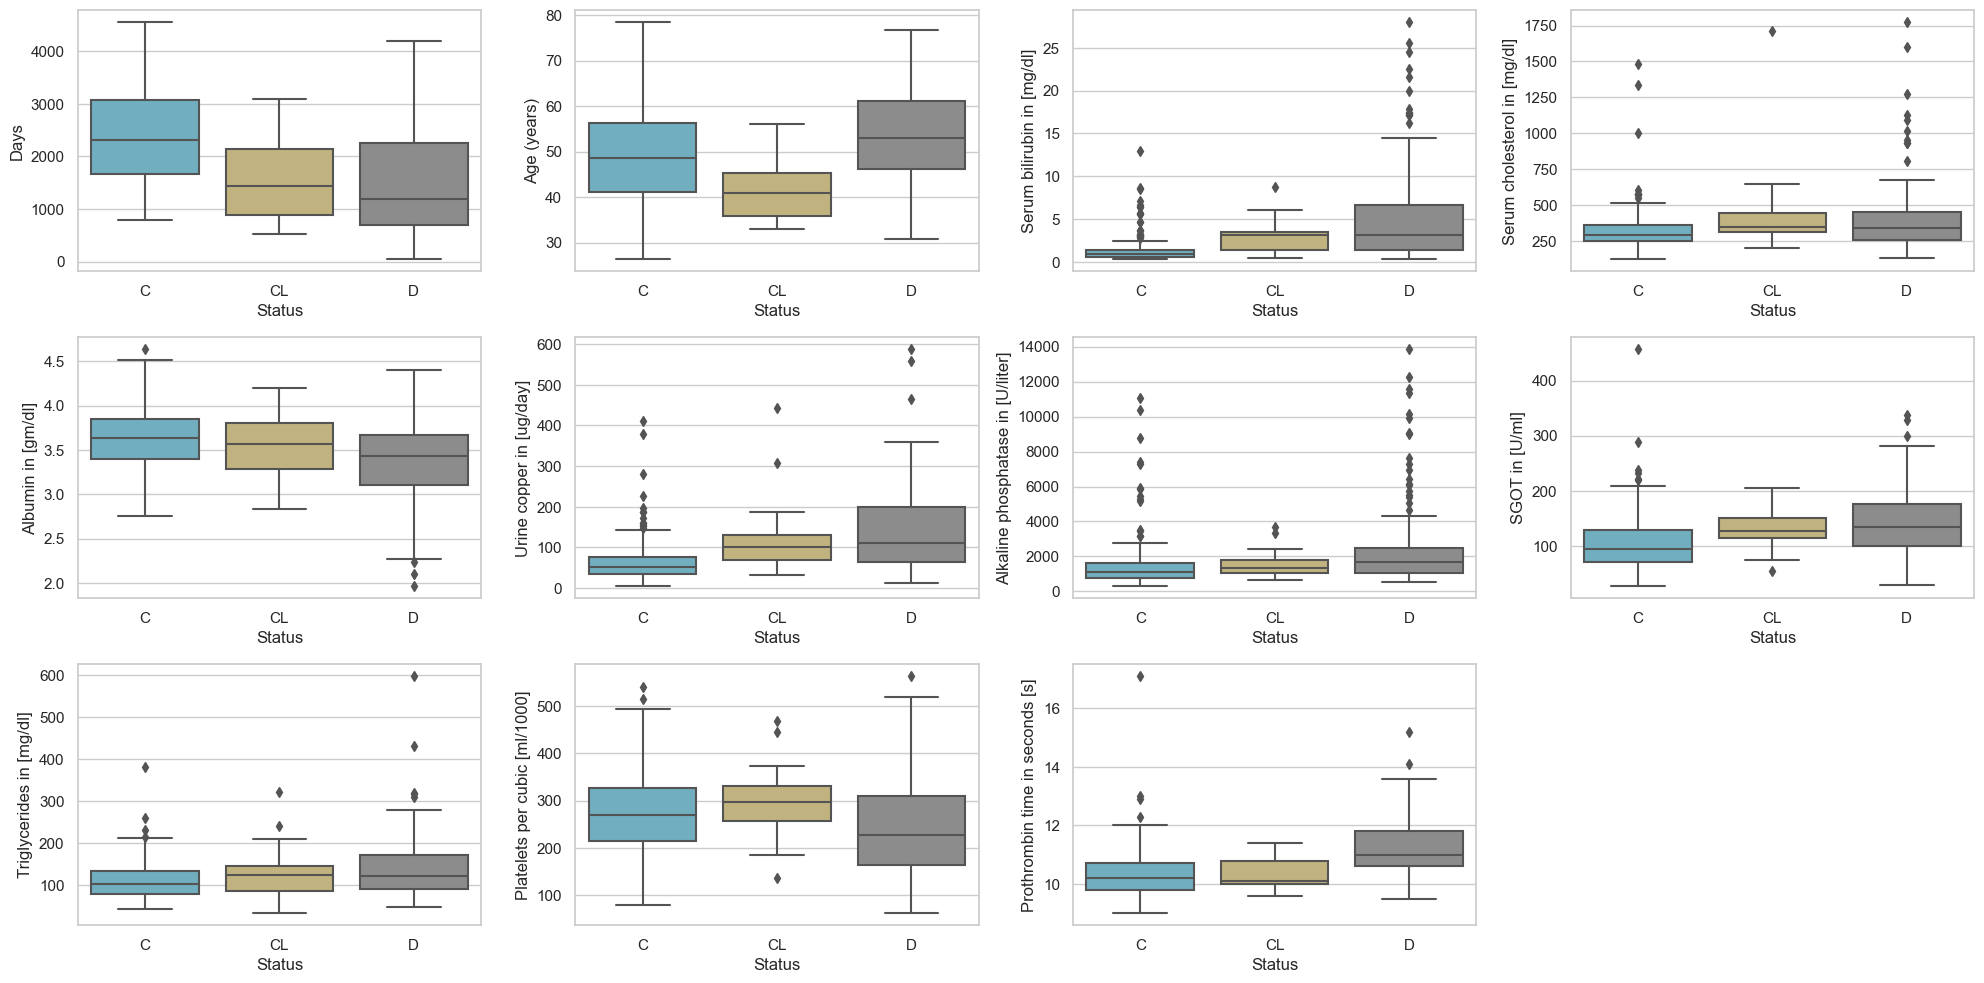

###########


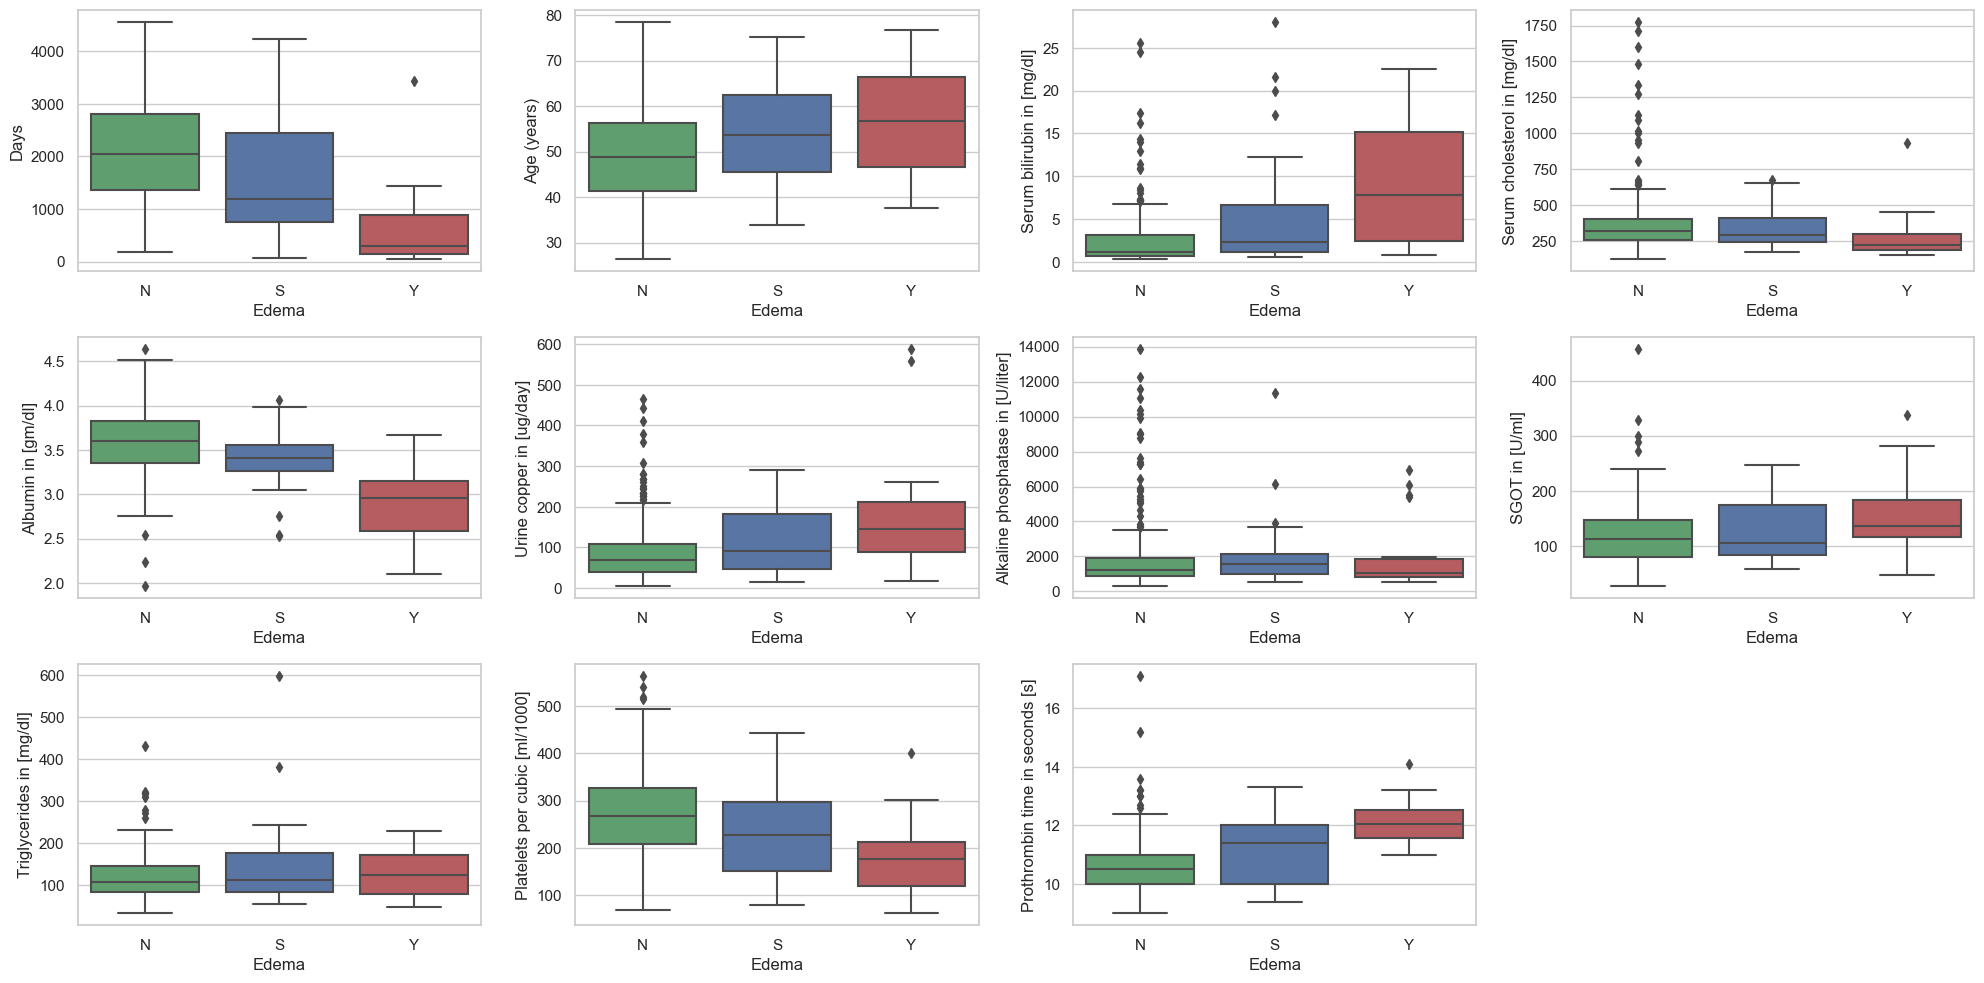

###########


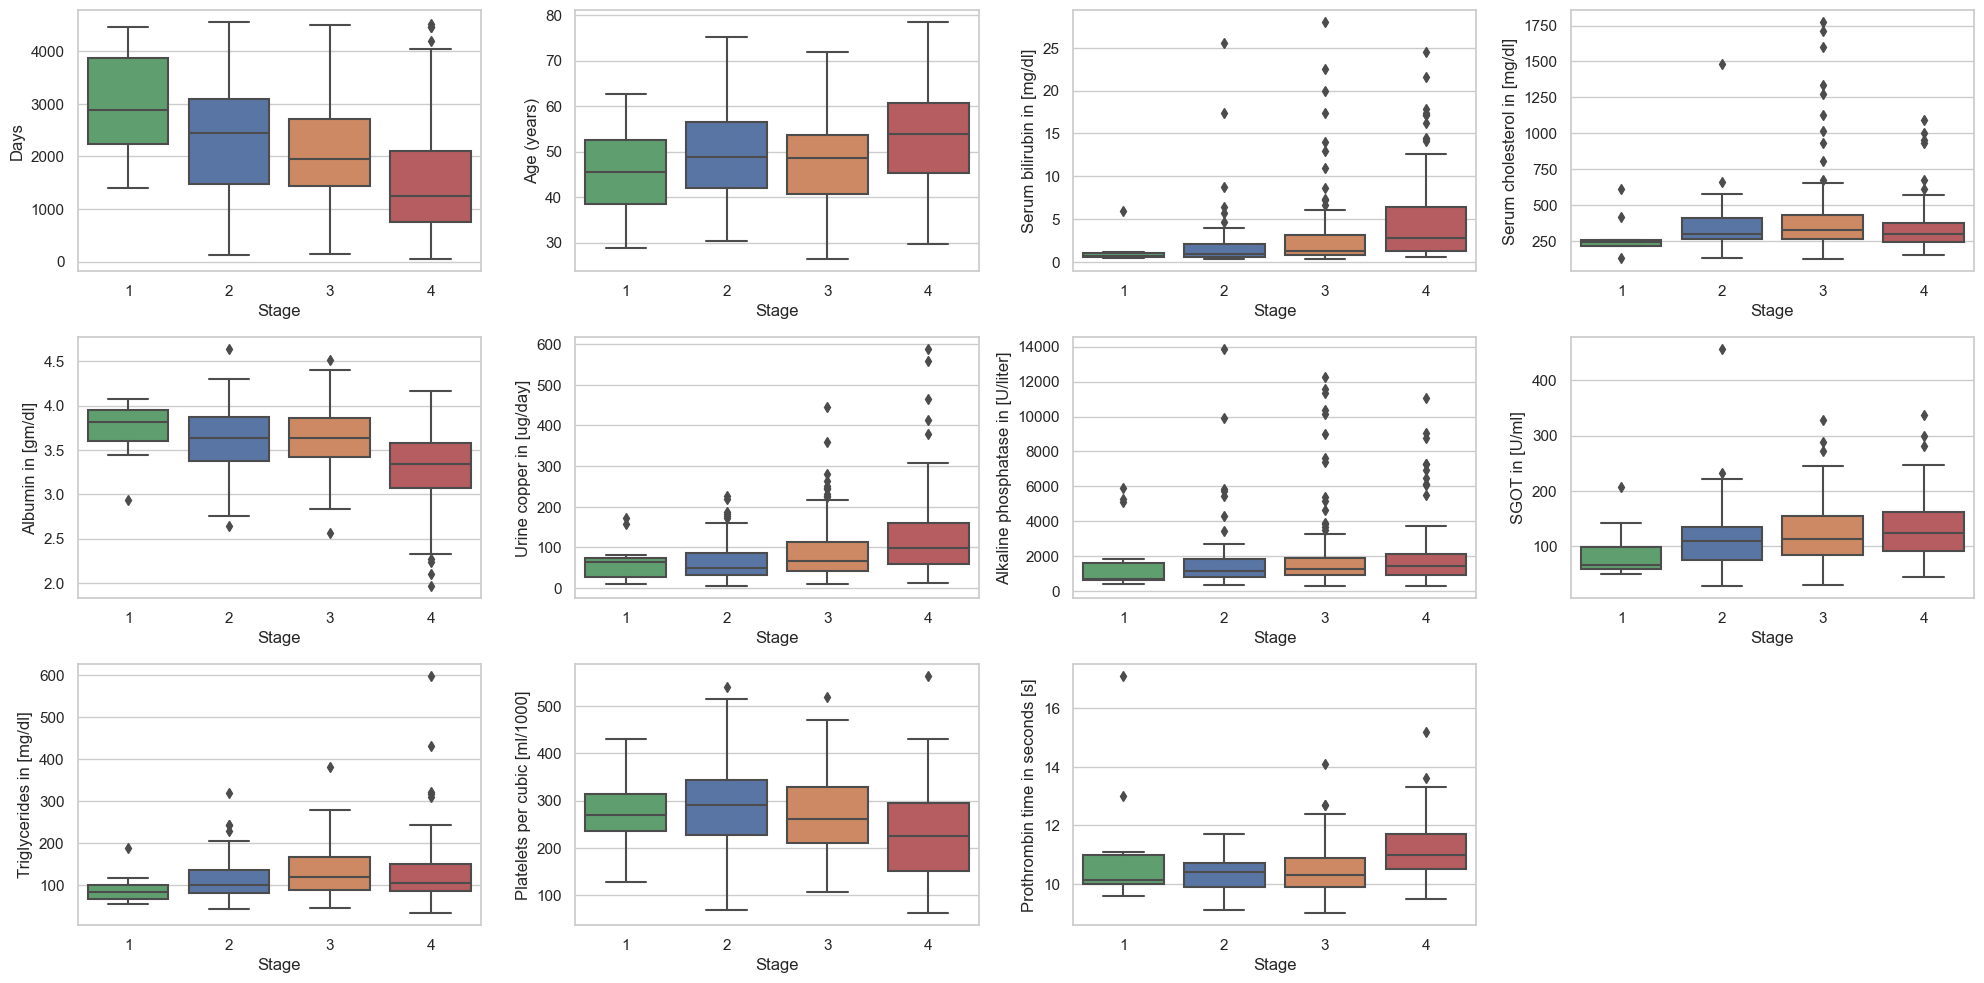

###########


In [60]:
for category in categoric_columns:
    # Define the figure size
    plt.figure(figsize=(20, 10))

    # Loop through each numeric column
    for i, column in enumerate(numeric_columns, 1):
        # Create a subplot
        plt.subplot(3, 4, i)
        
        # Plot the boxplot
        sns.boxplot(data=trials, x=category, y=column, palette=color_palette[category])
        
        # plt.xlabel(column_units.get(category, category))
        plt.ylabel(column_units.get(column, column))
        

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()
    print('###########')

numeric_columns = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

categoric_columns = ['Sex', 'Drug', 'Ascites', 'Hepatomegaly', 'Spiders', 'Status', 'Edema', 'Stage']

In [119]:
def plot_three_vars(y, x, color):   
    # Plot the boxplot
    sns.boxplot(data=trials, x=x, y=y, hue=color, palette=color_palette[color])
    
    # plt.xlabel(column_units.get(category, category))
    plt.ylabel(column_units.get(y, y))

    # Adjust layout to prevent overlapb
    plt.tight_layout()

    # Show the plot
    plt.show()

In [75]:
def plot_all_by_two_vars(x, color):
    # Define the figure size
    plt.figure(figsize=(20, 10))

    # Loop through each numeric column
    for i, column in enumerate(numeric_columns, 1):
        # Create a subplot
        plt.subplot(3, 4, i)
        
        # Plot the boxplot
        sns.boxplot(data=trials, x=x, y=column, hue=color, palette=color_palette[color])
        
        # plt.xlabel(column_units.get(category, category))
        plt.ylabel(column_units.get(column, column))
        

    # Adjust layout to prevent overlapb
    plt.tight_layout()

    # Show the plot
    plt.show()
    print('###########')

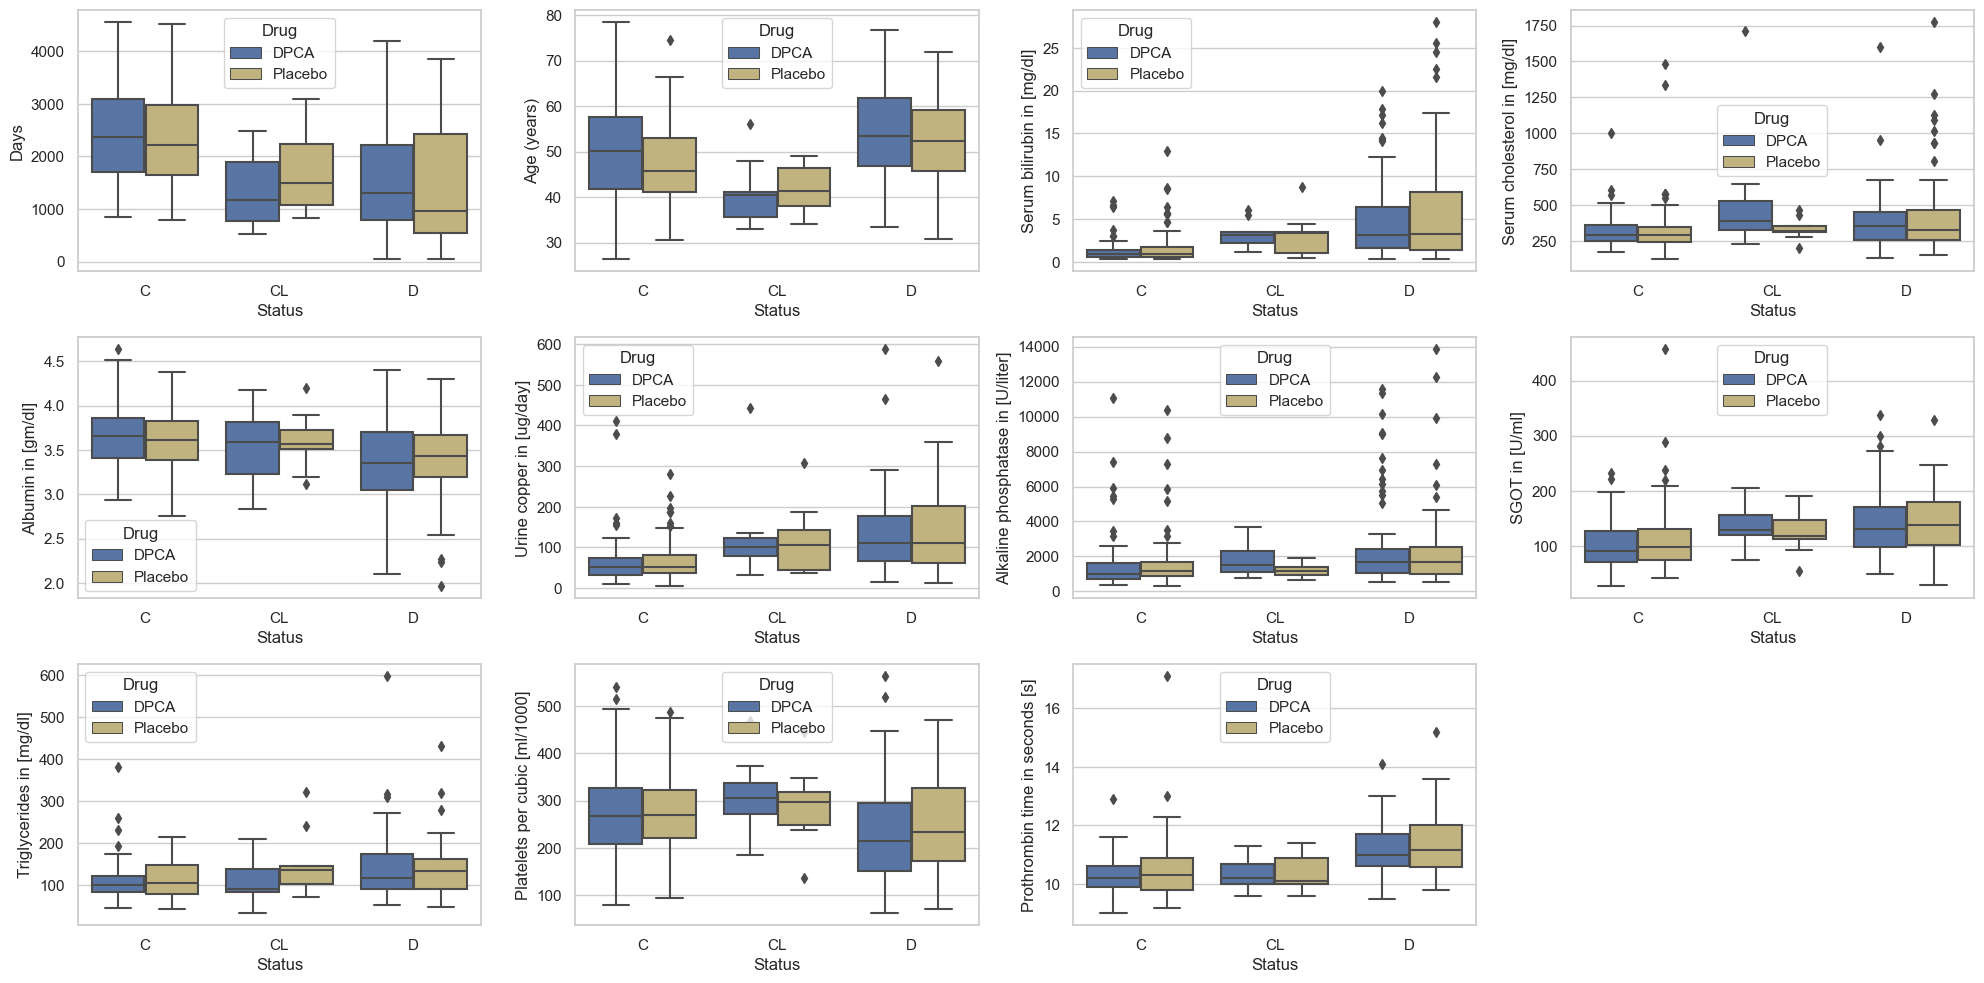

###########


In [93]:
plot_all_by_two_vars('Status', 'Drug')

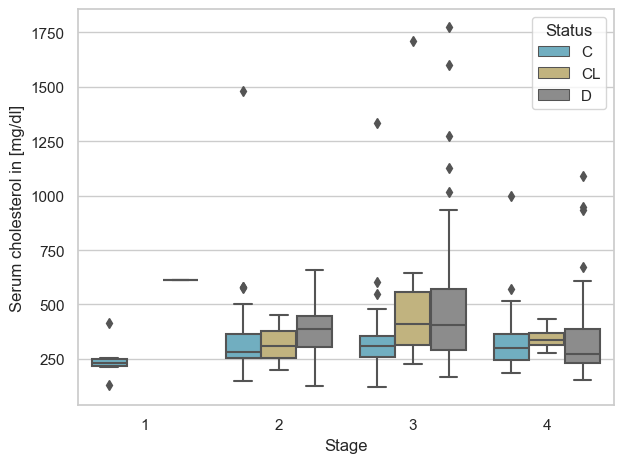

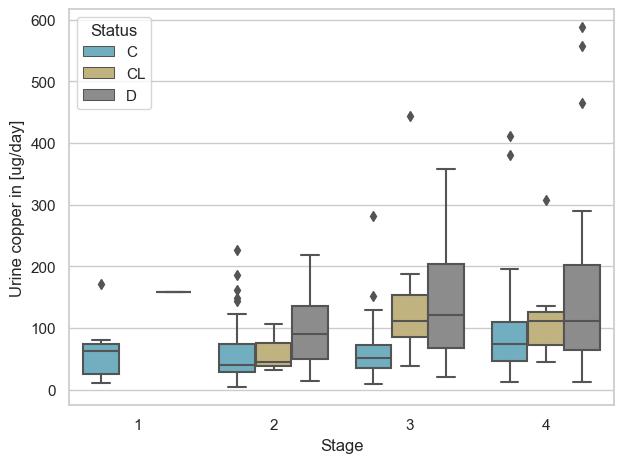

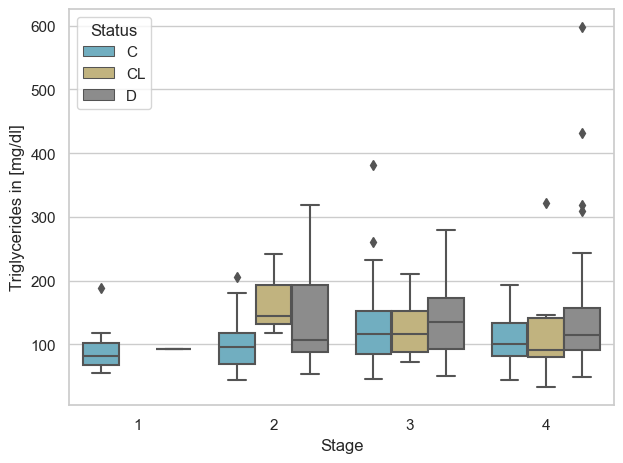

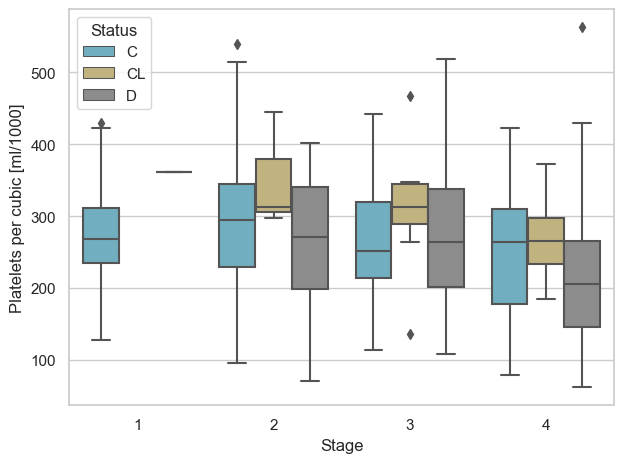

In [120]:
plot_three_vars('Cholesterol', 'Stage', 'Status')
plot_three_vars('Copper', 'Stage', 'Status')
plot_three_vars('Tryglicerides', 'Stage', 'Status')
plot_three_vars('Platelets', 'Stage', 'Status')

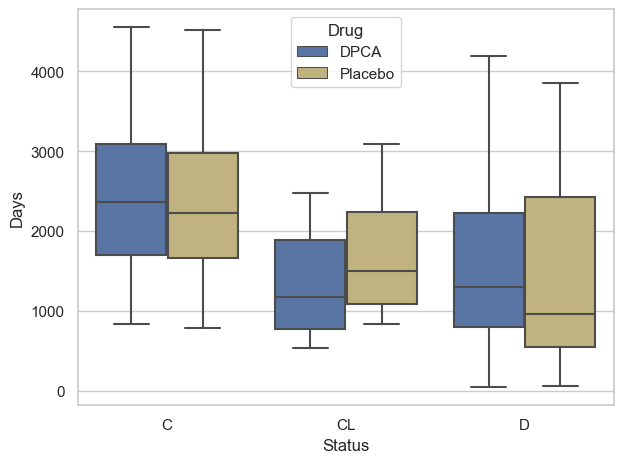

In [131]:
plot_three_vars('N_Days', 'Status', 'Drug')

<Figure size 1200x1000 with 0 Axes>

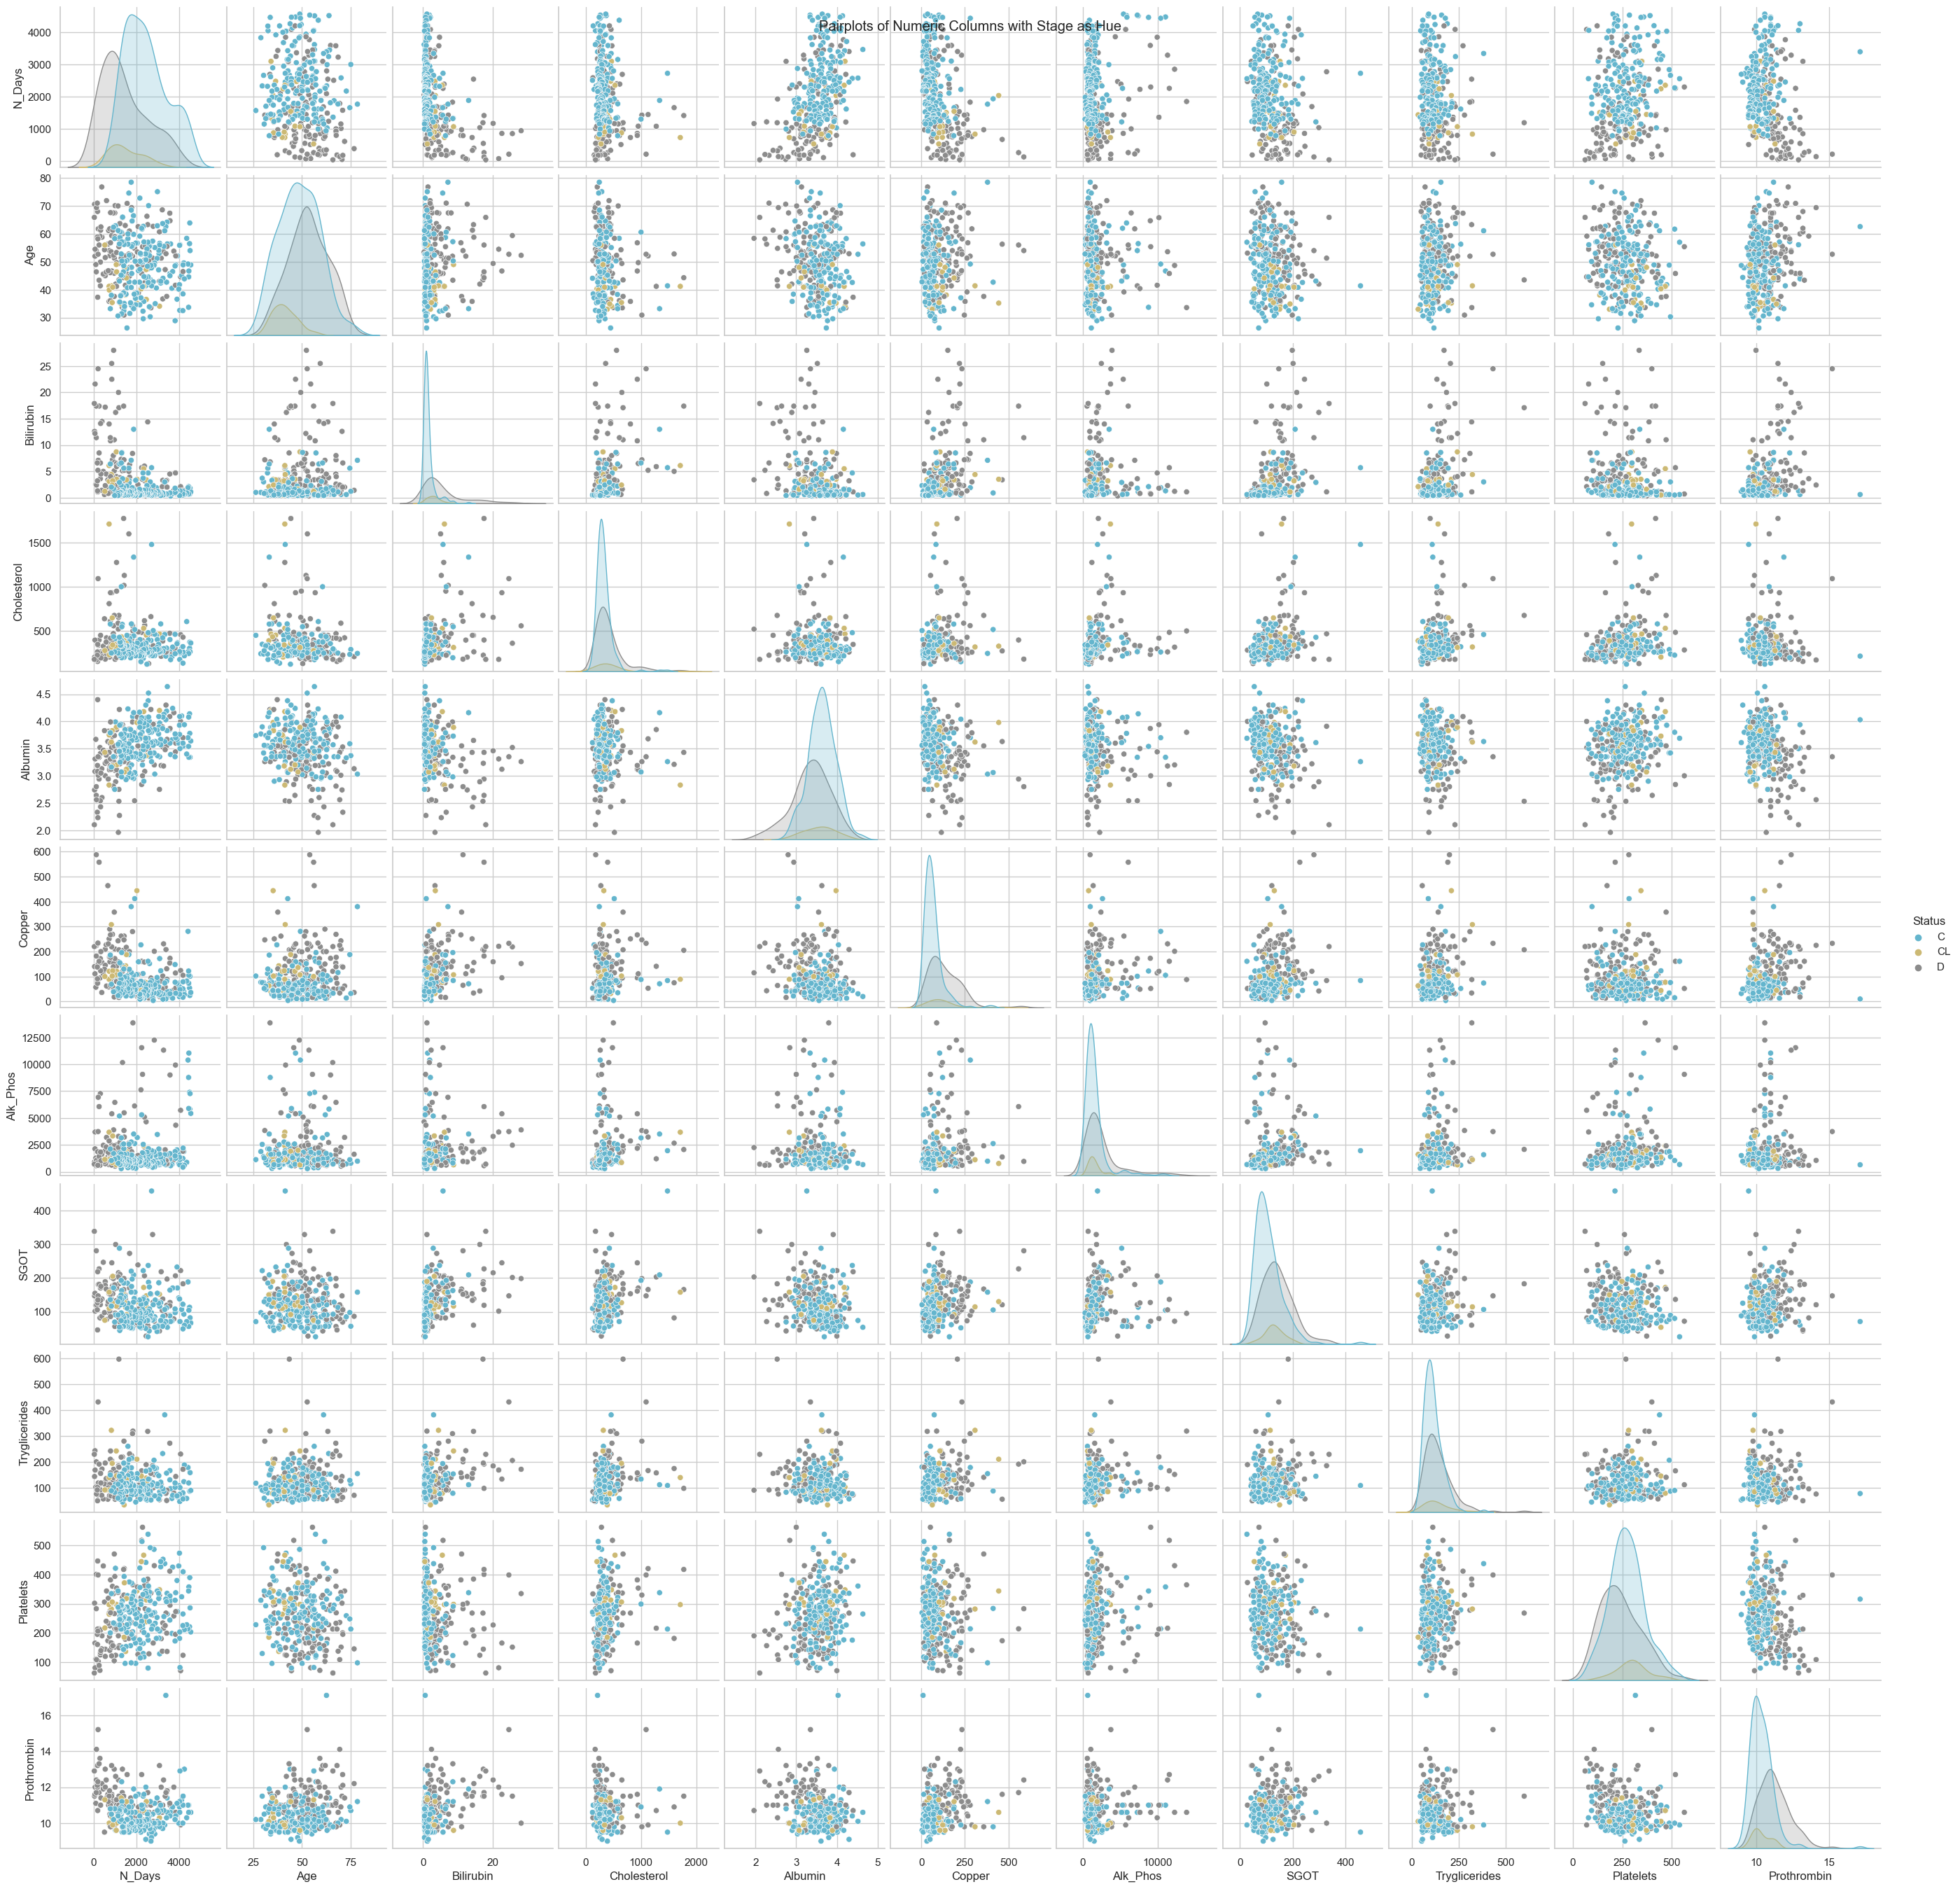

In [71]:
# Create pairplot with Stage as hue and custom palette
plt.figure(figsize=(12, 10))
sns.pairplot(data=trials, vars=numeric_columns, hue='Status', palette=color_palette['Status'], diag_kind='kde')
plt.suptitle("Pairplots of Numeric Columns with Stage as Hue")
plt.show()

Text(0, 0.5, 'Count')

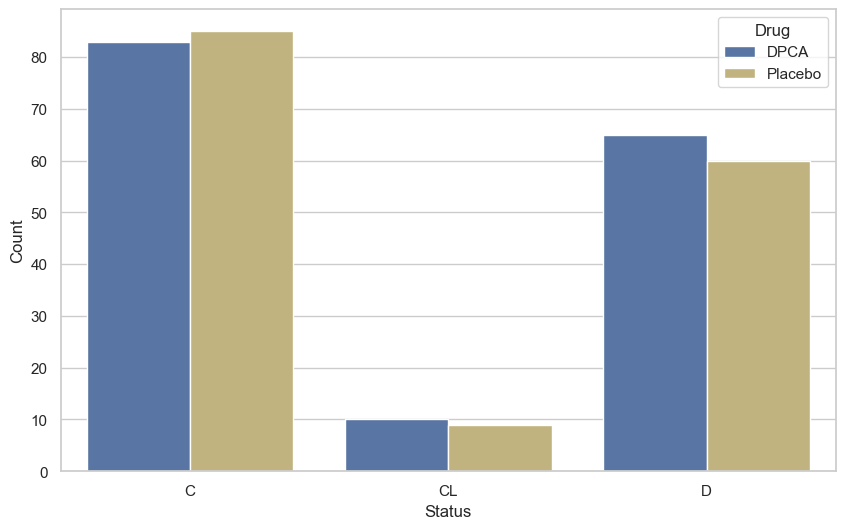

In [73]:
# Define the figure size
plt.figure(figsize=(10, 6))

# Create the bar plot
sns.countplot(data=trials, x='Status', hue='Drug', palette=color_palette['Drug'])

# Set the title and labels
plt.xlabel('Status')
plt.ylabel('Count')


In [15]:
# Calculate the correlation matrix
correlation_matrix = trials[numeric_columns].corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                 N_Days       Age  Bilirubin  Cholesterol   Albumin    Copper  \
N_Days         1.000000 -0.133562  -0.441793    -0.138236  0.435849 -0.364809   
Age           -0.133562  1.000000   0.038659    -0.157442 -0.195039  0.061655   
Bilirubin     -0.441793  0.038659   1.000000     0.397129 -0.334638  0.456918   
Cholesterol   -0.138236 -0.157442   0.397129     1.000000 -0.069733  0.126115   
Albumin        0.435849 -0.195039  -0.334638    -0.069733  1.000000 -0.264771   
Copper        -0.364809  0.061655   0.456918     0.126115 -0.264771  1.000000   
Alk_Phos       0.149269 -0.047280   0.116984     0.149473 -0.101456  0.187357   
SGOT          -0.225492 -0.149651   0.441730     0.353246 -0.220047  0.293829   
Tryglicerides -0.153000  0.022086   0.436748     0.276830 -0.103417  0.279852   
Platelets      0.192888 -0.139466  -0.086990     0.191710  0.204364 -0.064403   
Prothrombin   -0.168299  0.196316   0.361742    -0.030811 -0.234013  0.218224   

       

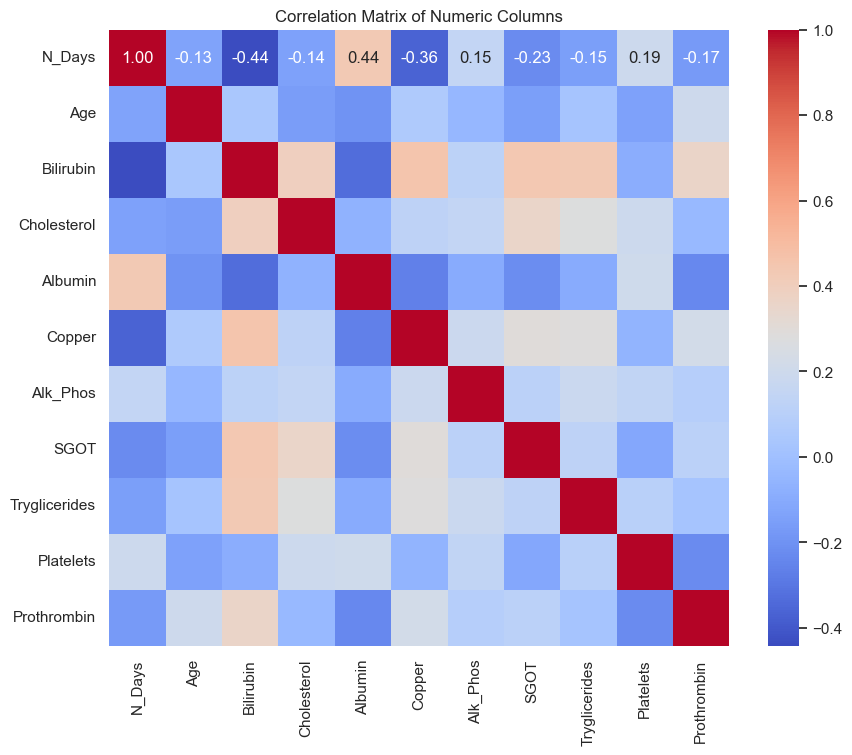

In [16]:
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numeric Columns")
plt.show()